In [1]:

import math

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from decimal import Decimal, getcontext
from glob import glob
from matplotlib.ticker import AutoMinorLocator
from scipy import optimize, stats
from scipy.interpolate import interp1d


### Loading the flat-field file for F1 filter

In [2]:
flatfile = "calibfile.fits"
flat = fits.getdata(flatfile)

## Functions

### Finding average flat-field

In [3]:

def avgFlat(Xf,Yf):
    w = 21
    ymin = int(Yf - w/2)
    ymax = int(Yf + w/2)
    xmin = int(Xf - w/2)
    xmax = int(Xf + w/2)

    flatregion = flat[ymin:ymax, xmin:xmax]
    avg_flat = np.sum(flatregion) / (flatregion.shape[0]*flatregion.shape[1])
    return avg_flat


### Applying aperture correction and saturation correction

In [4]:

radius = 12     # radius of aperture in sub-pixels

# Encircled energy data (https://doi.org/10.3847/1538-3881/ab72a3)
radius_pixels = np.array([ 1.5, 2, 2.5, 3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50, 70, 80, 95 ])

fuv_energy_percentage = np.array([ 28.1, 40.7, 51.1, 59.1, 68.9, 74.6, 81.4, 85.0, 88.6, 91.3, 94.5, 96.9, 97.7, 98.3, 99.1, 99.5, 100.0 ])
fuv_ratio = fuv_energy_percentage / 100.
fuv_ratio_function = interp1d(radius_pixels, fuv_ratio, kind = 'cubic')



#---------------------------------------------------------------------------#



# Aperture correction
# -------------------

def apply_aperture_correction(CPF, CPF_err, radius): 
    CPF = CPF / fuv_ratio_function(radius)
    CPF_err = CPF_err / fuv_ratio_function(radius)
    return CPF, CPF_err



#---------------------------------------------------------------------------#



# Saturation correction
# ---------------------

def apply_saturation_correction(CPF, CPF_err):
    
    CPF_original = CPF
    CPF5_err_original = CPF_err
    
    CPF5 = CPF * 0.97     # 97% of the photons (observed counts per frame) that fall in the central 5x5 pixel sq. region
    CPF5_err = CPF_err * 0.97    
    
    if np.sum(CPF5 >= 0.6) != 0:
        print("\nCounts per frame exeeds 0.6; saturation correction cannot be applied")
        return

    ICPF5 = -1 * np.log(1 - CPF5)     # the corresponding actual counts per frame as per Poissonian statistics
    ICPF5_err = CPF5_err / CPF5

    ICORR = ICPF5 - CPF5     # ideal correction for saturation
    ICORR_err = np.sqrt((ICPF5_err ** 2) + (CPF5_err ** 2))

    RCORR = ICORR * (0.89 - (0.30 * (ICORR ** 2)))     # real or actual correction for saturation derived from empirical results
    RCORR_err = RCORR * np.sqrt((ICORR_err ** 2) + ((0.30 * 2 * ICORR * ICORR_err) ** 2))

    CCPF5 = CPF_original + RCORR
    CCPF5_err = np.sqrt((CPF5_err_original ** 2) + (RCORR_err ** 2))       
    return CCPF5, CCPF5_err



#---------------------------------------------------------------------------#



# Applying aperture and saturation corrections
# --------------------------------------------

def apply_all_correction(CPS, CPS_err, radius, framecount_per_sec):

    """
    aperture_correction = None # valid inputs are None / 'fuv' / 'nuv'.
    saturation_correction = False # True or False.
    """

    CPF = CPS / framecount_per_sec
    CPF_err = CPS_err / framecount_per_sec

    CPF, CPF_err = apply_aperture_correction(CPF, CPF_err, radius)
    CPF, CPF_err = apply_saturation_correction(CPF, CPF_err)
    
    CPS = CPF * framecount_per_sec
    CPS_err = CPF_err * framecount_per_sec
    return CPS, CPS_err


### Converting Mission Ellapsed Time (MET) to Modified Julian Date (MJD)

In [5]:

# Rearranging the date values
# ---------------------------

def rearrange_date(date_val):
    return date_val[-2:] + "/" + date_val[-4:-2] + "/" + date_val[0:4]



# Converting Mission Ellapsed Time (MET) to Modified Julian Date (MJD)
# --------------------------------------------------------------------

def met_to_mjd(met):
    jan2010 = 55197.0  # 2010.0(UTC) expressed with MJD format and scale UTC.
    mjd = (met / 86400.0) + jan2010  # 1 julian day = 86400 seconds.
    return mjd


### Least Squares Fit (Linear Regression)

In [6]:

def func_best_fit(x, m, c):
    y = m*x + c
    return y


### Rounding off

In [7]:

def format_value_and_error(value, error):
    getcontext().rounding = 'ROUND_HALF_UP'
    
    # Convert inputs to Decimal to handle precision accurately
    d_value = Decimal(str(value))
    d_error = Decimal(str(error))
    
    if d_error <= Decimal('0'):
        raise ValueError("Error must be positive.")
    
    # Step 1: Round the error to one significant figure
    error_normalized = d_error.normalize()
    exponent = error_normalized.adjusted()  # Gets the exponent of the normalized form
    # Create a quantizer for one significant figure
    sig_fig_quant = Decimal('1e{}'.format(exponent))
    d_error_rounded = error_normalized.quantize(sig_fig_quant)
    
    # Step 2: Compute E_over_10 using the original error
    d_E_over_10 = d_error / Decimal('10')
    
    # Step 3: Determine the number of decimal places for the value
    if d_E_over_10 == Decimal('0'):
        decimal_places = 0
    else:
        # Convert to float for logarithm calculation
        E_over_10 = float(d_E_over_10)
        log = math.log10(1.0 / E_over_10)
        n = math.floor(log)
        decimal_places = int(n)
    
    # Step 4: Round the value to the determined decimal places
    if decimal_places >= 0:
        # For positive or zero decimal places, format as 0.000...
        quant = Decimal('1e-{}'.format(decimal_places))
    else:
        # For negative decimal places, round to the nearest 10, 100, etc.
        quant = Decimal('1e{}'.format(-decimal_places))
    d_rounded_value = d_value.quantize(quant)
    
    # Convert back to float for the output
    return (float(d_rounded_value), float(d_error_rounded))


# NGC188

#### Coordinates of the field center of the FITS image in instrument coordinates

In [8]:

field_center_coordinates_NGC188 = pd.read_csv("NGC188/Data_info/NGC188_field_center_coordinates.csv")
field_center_coordinates_NGC188 = field_center_coordinates_NGC188.reset_index(drop = True)

""" The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here. """

field_center_coordinates_NGC188


,Observation ID,x_c,y_c
0,LEVL2AS1UVT20191213C05_013T02_9000003364_uvt_01,2355.6575,2516.1062
1,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,2390.0394,2481.7243
2,LEVL2AS1UVT20191219C05_013T03_9000003376_uvt_01,2412.9606,2539.0274
3,LEVL2AS1UVT20180826C03_015T04_9000002328_uvt_02,2355.6575,2504.6456
4,LEVL2AS1UVT20180826C03_015T04_9000002328_uvt_03,2412.9606,2275.4332
5,LEVL2AS1UVT20180826C03_015T04_9000002328_uvt_01,2367.1181,2344.1969
6,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,2206.6695,2837.0036
7,LEVL2AS1UVT20211101T04_065T01_9000004750_uvt_02,2459.8031,2391.0394
8,LEVL2AS1UVT20210827C06_010T03_9000004672_uvt_02,2275.4332,2355.6575
9,LEVL2AS1UVT20210827C06_010T03_9000004672_uvt_03,2424.4212,2355.6575


#### Removing flat-fielding corrections

In [9]:

# Arrays for storing the data
# ---------------------------

X_FF_coord = []; Y_FF_coord = []
raw_cps_arr = []; raw_cps_err_arr = []; FF_arr = []
raw_cps = []; raw_cps_err = []; FF = []
AVGFRMRT = []



for i in range(0, len(field_center_coordinates_NGC188)):
    XC = field_center_coordinates_NGC188['x_c'][i] - 1  # X coordinate of the centre of the field
    YC = field_center_coordinates_NGC188['y_c'][i] - 1  # Y coordinate of the centre of the field
    
    """ The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here. 
        To bring it to zero indexing, we subtract -1 from the coordinates. """
    
    obs_ID = field_center_coordinates_NGC188['Observation ID'][i][:-7]
    obs_ID_orbit = field_center_coordinates_NGC188['Observation ID'][i][-6:]
    
    source_coord_I = pd.read_csv("NGC188/coord_cross_match/" + str(obs_ID) + "/" + field_center_coordinates_NGC188['Observation ID'][i] + 
                                 "_I_coord_matches.csv")
    
    
    
    # Converting source coordinates in the image to FLAT array coordinates
    # --------------------------------------------------------------------
    
    x = source_coord_I['x_center_source'] # X coordinate of star in the image
    y = source_coord_I['y_center_source'] # Y coordinate of star in the image

    x_flat = 256 + ((x - XC)/8) # X Coordinate of star in Flat array (appiled conversion)     array containing 4 elements for every candidate
    y_flat = 256 + ((y - YC)/8) # Y Coordinate of star in Flat array (appiled conversion)

    X_FF_coord.append(x_flat)
    Y_FF_coord.append(y_flat)
    
    
    
    # Removing flatfielding corrections
    # ---------------------------------
    
    measured_cps = source_coord_I['source_cps'] # measured counts per second of the star
    measured_cps_err = source_coord_I['source_err_cps']
    
    for j in range(0,4):
        FF_val = avgFlat(x_flat[j], y_flat[j]) # Average flat field value
        raw_cps_val = measured_cps[j]/FF_val # CPS after removing the flatfielding corrections (Raw CPS)
        raw_cps_err_val = measured_cps_err[j]/FF_val
        
        FF.append(FF_val)
        raw_cps.append(raw_cps_val)
        raw_cps_err.append(raw_cps_err_val)
        
    FF_arr.append(FF)
    raw_cps_arr.append(raw_cps)
    raw_cps_err_arr.append(raw_cps_err)
    
    FF = []
    raw_cps = []
    raw_cps_err = []
    
    
    
    # Calculating AVGFRMT
    # -------------------
    
    I_img_file = glob("NGC188/Data_astrobrowse/" + obs_ID + "/" + obs_ID_orbit + "*FIIP*F1I_l2img.fits.gz")
    hdu = fits.open(I_img_file[0])
    INT_TIME = hdu[0].header['INT_TIME']
    avg_frmrt = 1/INT_TIME
    AVGFRMRT.append(avg_frmrt)


#### Rearranging the information separately for each candidate (4 columns with 57 rows)

In [10]:

# Average flat-field (FF) and non-flat-fielded CPS (raw CPS)
FF_1, FF_2, FF_3, FF_4 = [[i[j] for i in FF_arr] for j in range(4)]
raw_cps_1, raw_cps_2, raw_cps_3, raw_cps_4 = [[j[k] for j in raw_cps_arr] for k in range(4)]
raw_cps_err_1, raw_cps_err_2, raw_cps_err_3, raw_cps_err_4 = [[j[k] for j in raw_cps_err_arr] for k in range(4)]

# X and Y flat-field coordinates
X_FF_1, X_FF_2, X_FF_3, X_FF_4 = [[i[j] for i in X_FF_coord] for j in range(4)]
Y_FF_1, Y_FF_2, Y_FF_3, Y_FF_4 = [[i[j] for i in Y_FF_coord] for j in range(4)]


#### Applying aperture and saturation corrections

In [11]:

CPS_sat_corr_col = []; CPS_sat_corr = []
CPS_err_sat_corr_col = []; CPS_err_sat_corr = []

for j in range(0,4):
    
    for i in range(0, len(field_center_coordinates_NGC188)):
        
        obs = field_center_coordinates_NGC188['Observation ID'][i]
        framecount_per_sec = AVGFRMRT[i]
        CPS = np.array(raw_cps_arr[i][j])
        CPS_err = np.array(raw_cps_err_arr[i][j])
        FF = np.array(FF_arr[i][j])
        
        CPF = CPS / framecount_per_sec
        CPF_err = CPS_err / framecount_per_sec
        
        CPS_sat_corr_val, CPS_err_sat_corr_val  = apply_all_correction(CPS, CPS_err, radius, framecount_per_sec)
        
        CPS_sat_corr.append(CPS_sat_corr_val)
        CPS_err_sat_corr.append(CPS_err_sat_corr_val)
        
    CPS_sat_corr_col.append(CPS_sat_corr)
    CPS_err_sat_corr_col.append(CPS_err_sat_corr)
    CPS_sat_corr = []
    CPS_err_sat_corr = []


#### Reintroduing flat-fielding corrections

In [12]:

CPS_sat_corr = CPS_sat_corr_col[:4]
CPS_err_sat_corr = CPS_err_sat_corr_col[:4]
FF_values = [FF_1, FF_2, FF_3, FF_4]

FF_corr_CPS = [np.multiply(CPS, FF) for CPS, FF in zip(CPS_sat_corr, FF_values)]
FF_corr_err_CPS = [np.multiply(CPS_err, FF) for CPS_err, FF in zip(CPS_err_sat_corr, FF_values)]

CPS_sat_corr_1, CPS_sat_corr_2, CPS_sat_corr_3, CPS_sat_corr_4 = CPS_sat_corr
CPS_err_sat_corr_1, CPS_err_sat_corr_2, CPS_err_sat_corr_3, CPS_err_sat_corr_4 = CPS_err_sat_corr
FF_corr_CPS_1, FF_corr_CPS_2, FF_corr_CPS_3, FF_corr_CPS_4 = FF_corr_CPS
FF_corr_err_CPS_1, FF_corr_err_CPS_2, FF_corr_err_CPS_3, FF_corr_err_CPS_4 = FF_corr_err_CPS


### Creating the master sheets

In [13]:

# Observation IDs in the field_center_coordinates dataframe

obs = field_center_coordinates_NGC188['Observation ID']



#---------------------------------------------------------------------------#



# Data Columns

x_coord_I_1, x_coord_I_2, x_coord_I_3, x_coord_I_4 = ([] for i in range(4))
y_coord_I_1, y_coord_I_2, y_coord_I_3, y_coord_I_4 = ([] for i in range(4))

coordinates_I_1, coordinates_I_2, coordinates_I_3, coordinates_I_4 = ([] for i in range(4))
coordinates_FF_1, coordinates_FF_2, coordinates_FF_3, coordinates_FF_4 = ([] for i in range(4))

source_aperture_CPS_1, source_aperture_CPS_2, source_aperture_CPS_3, source_aperture_CPS_4 = ([] for i in range(4))

candidate_1, candidate_2, candidate_3, candidate_4 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

date = []; exposure_time = []; mjd_time = []; UTC = []; median_background = []



#---------------------------------------------------------------------------#



# Background of the image

bkg_img_file = "NGC188/source_detection/source_bkg_NGC188.txt"
data_txt = np.genfromtxt(bkg_img_file, delimiter = ',', dtype = None, encoding = None)
data = np.array([row.split() for row in data_txt]).T

observation_id = data[0]
med_bkg = data[3]
median_bkg = pd.DataFrame(zip(observation_id, med_bkg), columns = ['Observation ID', 'Median_background'])



#---------------------------------------------------------------------------#



x_coord_I = [] ; y_coord_I = []

for i,j in zip(obs, median_bkg['Observation ID']):
    
    obs_id = i[:-7]
    orbit = i[-6:]

    ce_file_path = ("NGC188/Data_astrobrowse/" + obs_id + "/" + orbit + "_AS1" + obs_id[19:] + "uvtFIIPC00F1_l2ce.fits.gz")
    hdu_list = fits.open(ce_file_path)
    event_data = Table(hdu_list[1].data)
    met = np.median(np.unique(event_data['MJD_L2']))     # mission ellapsed time in seconds
    mjd = met_to_mjd(met)
    mjd_time.append(mjd)
    
    
    
    # UTC
    # ---
    
    t = Time(mjd, format = 'mjd')
    t_utc = t.utc.datetime
    UTC.append(t_utc)
    
    
    
    # Date of observation
    # -------------------
    
    date_val = t_utc.strftime("%d/%m/%Y")
    date.append(date_val)
    
    
    
    # Exposure time
    # -------------
    
    fits_file_path = ("NGC188/Data_astrobrowse/" + obs_id + "/" + orbit + "_AS1" + obs_id[19:] + "uvtFIIPC00F1I_l2img.fits.gz")
    fits_file = fits.open(fits_file_path)
    exp_time_val = fits_file[0].header['EXP_TIME']
    exposure_time.append(exp_time_val)
    
    
    
    # Median background
    # -----------------
    
    matched_obs_id = median_bkg.loc[median_bkg['Observation ID'] == i]
    median_bkg_val = matched_obs_id['Median_background'].tolist()
    median_background.append(median_bkg_val)
    
    
    
    # Reading csv files of the candidates
    # -----------------------------------
    
    source_coord_I_path = pd.read_csv("NGC188/coord_cross_match/" + obs_id + "/" + i + "_I_coord_matches.csv")    
    
    for candidate_number, index in zip(range(1,5), range(0,4)):
        
        candidate = eval("candidate_" + str(candidate_number))
        
        # Source coordinate information in instrumentation coordinates (I)
        x_coord_I = eval("x_coord_I_" + str(candidate_number))
        y_coord_I = eval("y_coord_I_" + str(candidate_number))
        x_coord_I.append(source_coord_I_path['x_center_source'][index])
        y_coord_I.append(source_coord_I_path['y_center_source'][index])
        
        # Background subtracted aperture CPS
        source_aperture_CPS = eval("source_aperture_CPS_" + str(candidate_number))
        #aperture_CPS = pd.read_csv("NGC188/coord_cross_match/" + obs_id + "/" + i + "_I_coord_matches.csv")
        source_aperture_CPS.append(source_coord_I_path['source_cps'][index])
        


for i in range(1,5):
    
    # Source coordinates in IMG
    coordinates_I = eval("coordinates_I_" + str(i))
    temp_x_coord_I = eval("x_coord_I_" + str(i))
    temp_y_coord_I = eval("y_coord_I_" + str(i))
    
    for xi, yi, in zip(temp_x_coord_I, temp_y_coord_I):
        coordinates_I.append([xi, yi])
    
    # Source coordinates in FF
    coordinates_FF = eval("coordinates_FF_" + str(i))
    temp_x_coord_FF = eval("X_FF_" + str(i))
    temp_y_coord_FF = eval("Y_FF_" + str(i))
    
    for xff, yff, in zip(temp_x_coord_FF, temp_y_coord_FF):
        coordinates_FF.append([xff, yff])


median_background_round = []
for i in median_background: 
    temp = '{:.3e}'.format(float(i[0]))
    median_background_round.append(temp)
    

#### Candidate 1

In [14]:
coordinates_I_1_round = []; coordinates_FF_1_round = []


for i,j in zip(coordinates_I_1, coordinates_FF_1):
    
    temp_i = [round(num,1) for num in i]
    coordinates_I_1_round.append(temp_i)
    
    temp_ff = [round(num,1) for num in j]
    coordinates_FF_1_round.append(temp_ff)


candidate_1 = pd.DataFrame(zip(obs, date, exposure_time, mjd_time, coordinates_I_1_round, median_background_round, source_aperture_CPS_1, 
                               coordinates_FF_1_round, FF_1, raw_cps_1, CPS_sat_corr_1, FF_corr_CPS_1, FF_corr_err_CPS_1), 
                           columns = ['Observation', 'Date of observation', 'Exposure time', 'MJD_Time', 'Source coordinates (I)', 
                                      'Median background', 'Bkg-subtracted aperture CPS', 'Flat-field coordinates', 'Flat-field Correction', 
                                      'Raw CPS (without FF)', 'Saturation corrected CPS', 'Final flat-field corrected CPS', 
                                      'Errors for the final flat-field corrected CPS'])

candidate_1 = candidate_1.sort_values(by = 'MJD_Time', ascending = True).reset_index(drop = True)
candidate_1 = candidate_1.round({'Exposure time':3, 'Bkg-subtracted aperture CPS':3, 'Flat-field Correction':3, 'Raw CPS (without FF)':3, 
                                 'Saturation corrected CPS':3, 'Final flat-field corrected CPS':3, 
                                 'Errors for the final flat-field corrected CPS':3})

candidate_1 = candidate_1.reset_index(drop = True)
candidate_1.to_csv("master_sheets/candidate_1.csv", index = False)

candidate_1

,Observation,Date of observation,Exposure time,MJD_Time,Source coordinates (I),Median background,Bkg-subtracted aperture CPS,Flat-field coordinates,Flat-field Correction,Raw CPS (without FF),Saturation corrected CPS,Final flat-field corrected CPS,Errors for the final flat-field corrected CPS
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,22/03/2016,561.901,57469.570555,"[3146.3, 2294.7]",3.698e-05,11.695,"[344.9, 278.6]",0.998,11.722,16.917,16.879,0.170
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,22/03/2016,466.487,57469.624789,"[2933.6, 2364.5]",5.036e-05,12.086,"[322.6, 257.2]",0.997,12.117,17.676,17.631,0.191
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,18/05/2016,1105.032,57526.813515,"[2526.5, 2312.1]",3.830e-05,11.775,"[273.2, 234.9]",0.995,11.835,17.132,17.046,0.122
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,15/09/2016,621.101,57646.251297,"[2065.2, 1828.4]",3.967e-05,11.938,"[259.9, 224.6]",0.997,11.976,17.403,17.348,0.164
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,30/01/2017,1194.736,57783.493738,"[2378.4, 2622.3]",3.160e-05,11.835,"[277.6, 229.3]",0.994,11.912,17.279,17.169,0.118
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,16/04/2017,306.510,57859.093016,"[2628.6, 2019.6]",4.857e-05,11.901,"[280.2, 228.4]",0.994,11.975,17.401,17.293,0.233
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,16/04/2017,433.197,57859.214414,"[2931.4, 2135.0]",4.111e-05,11.904,"[280.8, 228.5]",0.994,11.979,17.410,17.300,0.196
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,16/04/2017,351.780,57859.283817,"[2940.6, 2027.6]",4.496e-05,11.495,"[283.4, 232.3]",0.993,11.574,16.637,16.523,0.213
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,21/12/2017,148.589,58108.583729,"[2980.3, 2602.6]",4.255e-05,11.784,"[324.2, 277.0]",1.002,11.757,16.984,17.021,0.333
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,23/02/2018,1854.627,58172.450870,"[2740.9, 2252.4]",3.437e-05,11.872,"[278.5, 231.8]",0.994,11.948,17.349,17.239,0.095


#### Candidate 2

In [15]:
coordinates_I_2_round = []; coordinates_FF_2_round = []


for i,j in zip(coordinates_I_2, coordinates_FF_2):
    
    temp_i = [round(num,1) for num in i]
    coordinates_I_2_round.append(temp_i)
    
    temp_ff = [round(num,1) for num in j]
    coordinates_FF_2_round.append(temp_ff)


candidate_2 = pd.DataFrame(zip(obs, date, exposure_time, mjd_time, coordinates_I_2_round, median_background_round, source_aperture_CPS_2, 
                               coordinates_FF_2_round, FF_2, raw_cps_2, CPS_sat_corr_2, FF_corr_CPS_2, FF_corr_err_CPS_2), 
                           columns = ['Observation', 'Date of observation', 'Exposure time', 'MJD_Time', 'Source coordinates (I)', 
                                      'Median background', 'Bkg-subtracted aperture CPS', 'Flat-field coordinates', 'Flat-field Correction', 
                                      'Raw CPS (without FF)', 'Saturation corrected CPS', 'Final flat-field corrected CPS', 
                                      'Errors for the final flat-field corrected CPS'])

candidate_2 = candidate_2.sort_values(by = 'MJD_Time', ascending = True).reset_index(drop = True)
candidate_2 = candidate_2.round({'Exposure time':3, 'Bkg-subtracted aperture CPS':3, 'Flat-field Correction':3, 'Raw CPS (without FF)':3, 
                                 'Saturation corrected CPS':3, 'Final flat-field corrected CPS':3, 
                                 'Errors for the final flat-field corrected CPS':3})

candidate_2 = candidate_2.reset_index(drop = True)
candidate_2.to_csv("master_sheets/candidate_2.csv", index = False)

candidate_2

,Observation,Date of observation,Exposure time,MJD_Time,Source coordinates (I),Median background,Bkg-subtracted aperture CPS,Flat-field coordinates,Flat-field Correction,Raw CPS (without FF),Saturation corrected CPS,Final flat-field corrected CPS,Errors for the final flat-field corrected CPS
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,22/03/2016,561.901,57469.570555,"[3934.8, 2530.5]",3.698e-05,8.406,"[443.5, 308.1]",1.009,8.327,11.044,11.148,0.140
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,22/03/2016,466.487,57469.624789,"[3725.5, 2587.9]",5.036e-05,8.383,"[421.6, 285.2]",0.998,8.401,11.161,11.138,0.154
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,18/05/2016,1105.032,57526.813515,"[3172.8, 1803.1]",3.830e-05,8.450,"[354.0, 171.3]",0.999,8.457,11.250,11.241,0.100
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,15/09/2016,621.101,57646.251297,"[1320.2, 1480.3]",3.967e-05,8.518,"[166.8, 181.1]",1.021,8.345,11.072,11.302,0.134
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,30/01/2017,1194.736,57783.493738,"[2734.4, 3363.6]",3.160e-05,8.587,"[322.1, 321.9]",1.002,8.574,11.437,11.454,0.097
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,16/04/2017,306.510,57859.093016,"[3446.4, 1929.7]",4.857e-05,8.456,"[382.4, 217.2]",0.989,8.548,11.395,11.272,0.191
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,16/04/2017,433.197,57859.214414,"[3749.3, 2045.2]",4.111e-05,8.398,"[383.1, 217.3]",0.989,8.492,11.305,11.181,0.160
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,16/04/2017,351.780,57859.283817,"[3758.5, 1938.0]",4.496e-05,8.293,"[385.6, 221.1]",0.988,8.397,11.155,11.016,0.176
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,21/12/2017,148.589,58108.583729,"[2741.5, 3390.0]",4.255e-05,8.301,"[294.3, 375.4]",1.006,8.254,10.929,10.991,0.271
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,23/02/2018,1854.627,58172.450870,"[3346.2, 2809.2]",3.437e-05,8.346,"[354.2, 301.4]",0.994,8.393,11.149,11.087,0.077


#### Candidate 3

In [16]:
coordinates_I_3_round = []; coordinates_FF_3_round = []


for i,j in zip(coordinates_I_3, coordinates_FF_3):
    
    temp_i = [round(num,1) for num in i]
    coordinates_I_3_round.append(temp_i)
    
    temp_ff = [round(num,1) for num in j]
    coordinates_FF_3_round.append(temp_ff)


candidate_3 = pd.DataFrame(zip(obs, date, exposure_time, mjd_time, coordinates_I_3_round, median_background_round, source_aperture_CPS_3, 
                               coordinates_FF_3_round, FF_3, raw_cps_3, CPS_sat_corr_3, FF_corr_CPS_3, FF_corr_err_CPS_3), 
                           columns = ['Observation', 'Date of observation', 'Exposure time', 'MJD_Time', 'Source coordinates (I)', 
                                      'Median background', 'Bkg-subtracted aperture CPS', 'Flat-field coordinates', 'Flat-field Correction', 
                                      'Raw CPS (without FF)', 'Saturation corrected CPS', 'Final flat-field corrected CPS', 
                                      'Errors for the final flat-field corrected CPS'])

candidate_3 = candidate_3.sort_values(by = 'MJD_Time', ascending = True).reset_index(drop = True)
candidate_3 = candidate_3.round({'Exposure time':3, 'Bkg-subtracted aperture CPS':3, 'Flat-field Correction':3, 'Raw CPS (without FF)':3, 
                                 'Saturation corrected CPS':3, 'Final flat-field corrected CPS':3, 
                                 'Errors for the final flat-field corrected CPS':3})

candidate_3 = candidate_3.reset_index(drop = True)
candidate_3.to_csv("master_sheets/candidate_3.csv", index = False)

candidate_3

,Observation,Date of observation,Exposure time,MJD_Time,Source coordinates (I),Median background,Bkg-subtracted aperture CPS,Flat-field coordinates,Flat-field Correction,Raw CPS (without FF),Saturation corrected CPS,Final flat-field corrected CPS,Errors for the final flat-field corrected CPS
0,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_06,22/03/2016,561.901,57469.570555,"[3078.5, 3304.2]",3.698e-05,0.765,"[336.5, 404.8]",1.012,0.756,0.864,0.875,0.042
1,LEVL2AS1UVT20160322T01_034T01_9000000392_uvt_05,22/03/2016,466.487,57469.624789,"[2882.2, 3374.5]",5.036e-05,0.780,"[316.2, 383.5]",1.005,0.777,0.888,0.892,0.046
2,LEVL2AS1UVT20160518G05_209T01_9000000458_uvt_09,18/05/2016,1105.032,57526.813515,"[3312.9, 2948.1]",3.830e-05,0.775,"[371.5, 314.4]",0.989,0.783,0.896,0.886,0.030
3,LEVL2AS1UVT20160915G05_258T01_9000000666_uvt_08,15/09/2016,621.101,57646.251297,"[2279.7, 839.1]",3.967e-05,0.863,"[286.7, 100.9]",1.048,0.823,0.942,0.988,0.042
4,LEVL2AS1UVT20170130C02_016T01_9000000992_uvt_01,30/01/2017,1194.736,57783.493738,"[1586.5, 3251.1]",3.160e-05,0.895,"[178.6, 307.9]",1.029,0.870,0.996,1.025,0.031
5,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_04,16/04/2017,306.510,57859.093016,"[2958.6, 2975.2]",4.857e-05,0.786,"[321.5, 347.9]",0.999,0.786,0.899,0.898,0.057
6,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_02,16/04/2017,433.197,57859.214414,"[3261.5, 3090.8]",4.111e-05,0.780,"[322.1, 348.0]",0.999,0.781,0.893,0.892,0.048
7,LEVL2AS1UVT20170416C02_030T01_9000001168_uvt_01,16/04/2017,351.780,57859.283817,"[3270.6, 2983.6]",4.496e-05,0.732,"[324.7, 351.8]",1.000,0.732,0.837,0.837,0.051
8,LEVL2AS1UVT20171221C03_015T01_9000001788_uvt_01,21/12/2017,148.589,58108.583729,"[1971.5, 2530.6]",4.255e-05,0.778,"[198.1, 268.0]",1.023,0.760,0.869,0.889,0.082
9,LEVL2AS1UVT20180222T02_002T01_9000001914_uvt_02,23/02/2018,1854.627,58172.450870,"[2238.0, 3129.7]",3.437e-05,0.841,"[215.6, 341.4]",1.016,0.827,0.947,0.962,0.024


### Short-term sensitivity variation

MJD midpoint: 59010.0
Global average CPS: 16.98302  Error: 0.02446

Slope: -0.0002576190003443955  Error: 4.020028826177891e-05
Intercept at 59010.0 MJD : 17.022  Error: 0.03729
Chi-square value: 196.5

                                  WLS Regression Results                                  
Dep. Variable:     Final flat-field corrected CPS   R-squared:                       0.427
Model:                                        WLS   Adj. R-squared:                  0.417
Method:                             Least Squares   F-statistic:                     41.07
Date:                            Mon, 14 Jul 2025   Prob (F-statistic):           3.50e-08
Time:                                    17:41:09   Log-Likelihood:                -12.342
No. Observations:                              57   AIC:                             28.68
Df Residuals:                                  55   BIC:                             32.77
Df Model:                                       1                    

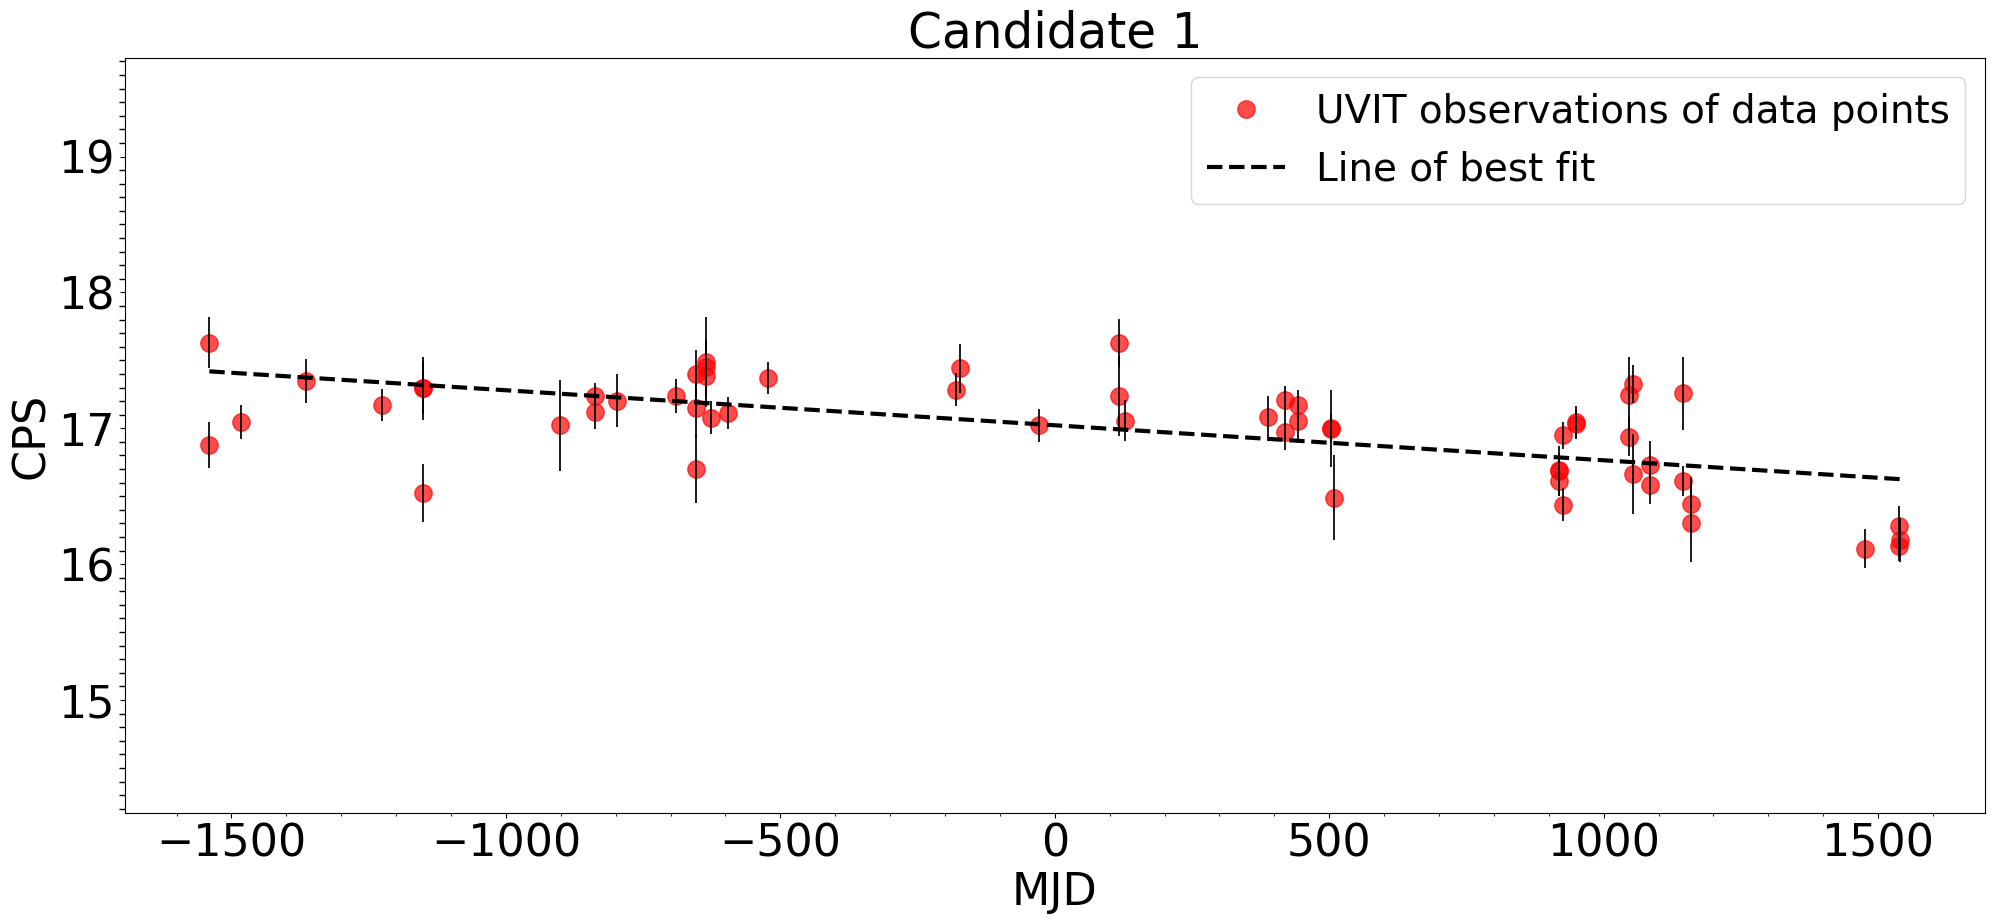

MJD midpoint: 59010.0
Global average CPS: 11.13993  Error: 0.02009

Slope: -0.00013491463534297303  Error: 3.522719791726776e-05
Intercept at 59010.0 MJD : 11.172  Error: 0.03269
Chi-square value: 223.849

                                  WLS Regression Results                                  
Dep. Variable:     Final flat-field corrected CPS   R-squared:                       0.211
Model:                                        WLS   Adj. R-squared:                  0.196
Method:                             Least Squares   F-statistic:                     14.67
Date:                            Mon, 14 Jul 2025   Prob (F-statistic):           0.000331
Time:                                    17:41:10   Log-Likelihood:                -4.8702
No. Observations:                              57   AIC:                             13.74
Df Residuals:                                  55   BIC:                             17.83
Df Model:                                       1                 

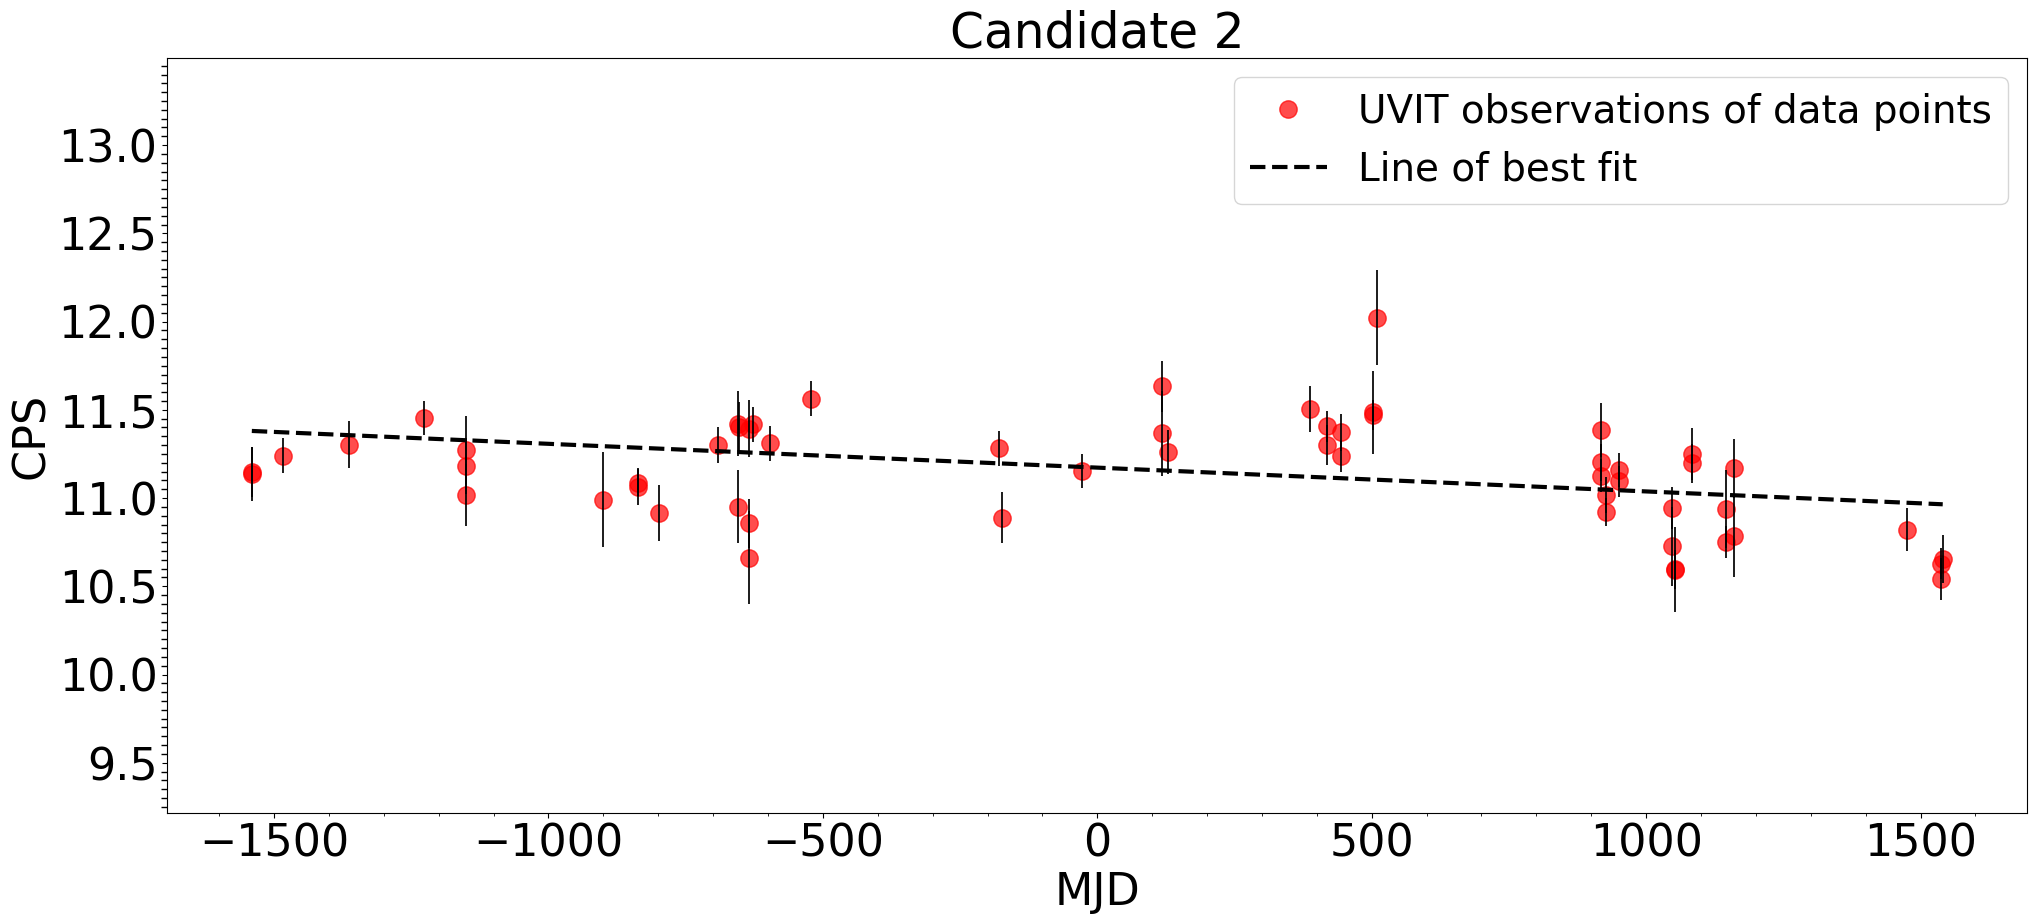

MJD midpoint: 59010.0
Global average CPS: 0.92623  Error: 0.00613

Slope: -1.1315800859047303e-05  Error: 6.332878339210191e-06
Intercept at 59010.0 MJD : 0.931  Error: 0.00588
Chi-square value: 77.537

                                  WLS Regression Results                                  
Dep. Variable:     Final flat-field corrected CPS   R-squared:                       0.055
Model:                                        WLS   Adj. R-squared:                  0.038
Method:                             Least Squares   F-statistic:                     3.193
Date:                            Mon, 14 Jul 2025   Prob (F-statistic):             0.0795
Time:                                    17:41:11   Log-Likelihood:                 93.031
No. Observations:                              57   AIC:                            -182.1
Df Residuals:                                  55   BIC:                            -178.0
Df Model:                                       1                    

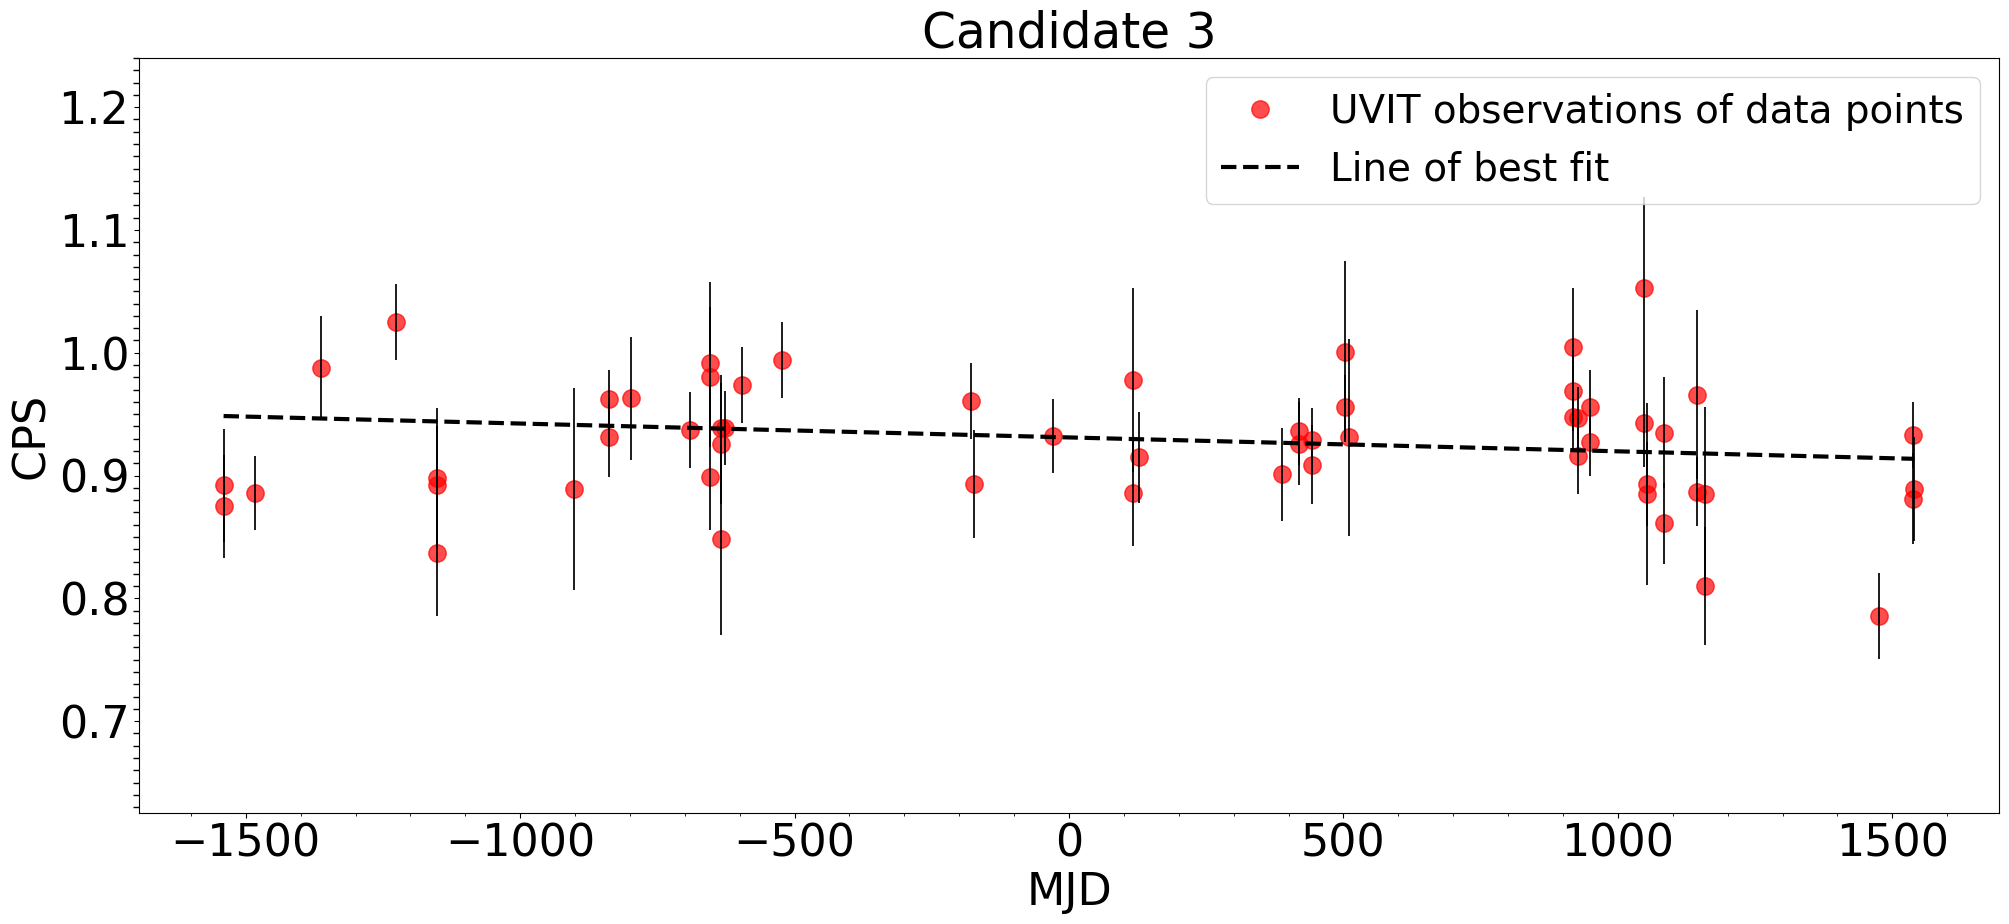

In [17]:

residual_fit_1 = [] ; residual_fit_2 = [] ; residual_fit_3 = [] ; residual_fit_4 = []

y_predicted_1 = [] ; y_predicted_2 = [] ; y_predicted_3 = [] ; y_predicted_4 = []
m_fit_arr = [] ; c_fit_arr = []

mjd_midpoint_ngc188_uvit = [] ; globavg_ngc188_uvit_cps = [] ; globavg_ngc188_uvit_cps_err = [] 




for i in [1,2,3]:
    
    candidate = eval("candidate_" + str(i))
    residual_fit = eval("residual_fit_" + str(i))
    y_predicted_arr = eval("y_predicted_" + str(i))
    
    
    
    # MJD midpoint
    # ------------
    
    mjd_midpoint = (candidate['MJD_Time'].iloc[-1] + candidate['MJD_Time'].iloc[0]) / 2
    mjd_midpoint_ngc188_uvit.append(mjd_midpoint)
    print('MJD midpoint:', np.round(mjd_midpoint, 1))
    
    
    
    x = candidate['MJD_Time'] - mjd_midpoint
    y = candidate['Final flat-field corrected CPS']
    y_errors = candidate['Errors for the final flat-field corrected CPS']
    
    
    
    # Global average
    # --------------
    
    global_avg = np.mean(candidate['Final flat-field corrected CPS'])
    globavg_ngc188_uvit_cps.append(global_avg)
    
    # Adding errors in quadrature
    num_err = len(y_errors)
    sum_of_squares = sum(error ** 2 for error in y_errors)
    y_err = math.sqrt(sum_of_squares)/num_err
    globavg_ngc188_uvit_cps_err.append(y_err)
    print('Global average CPS:', np.round(global_avg, 5), ' Error:', np.round(y_err, 5))
    
    
    
    # Performing least squares
    # ------------------------
    
    alpha, cov = optimize.curve_fit(func_best_fit, xdata = x, ydata = y, sigma = y_errors)
    
    m_fit = alpha[0]
    c_fit = alpha[1]
    d_m = np.sqrt(cov[0][0])
    d_c = np.sqrt(cov[1][1])
    
    m_fit_arr.append(m_fit)
    c_fit_arr.append(c_fit)
    
    y_predicted = m_fit*x + c_fit
    y_predicted_arr.append(y_predicted)
    
    residuals = y - y_predicted
    residual_fit.append(residuals)
    chi_squared_fit = np.sum((residuals ** 2) / y_errors**2)
    
    print("")
    
    print('Slope:', m_fit, ' Error:', d_m)
    print('Intercept at ' + str(np.round(mjd_midpoint, 1)) + ' MJD :', np.round(c_fit, 3), ' Error:', np.round(d_c, 5))    
    print('Chi-square value:', np.round(chi_squared_fit, 3))
    print("")
    
    
    
    #---------------------------------------------------------------------------#
    
    # STATSMODELS
    
    X = np.column_stack([np.ones_like(y), x])
    model = sm.WLS(y, X, weights = 1/y_errors**2)
    fit = model.fit()
    
    # Get prediction results
    pred = fit.get_prediction(X)
    pred_summary = pred.summary_frame(alpha = 0.05)  # 95% confidence intervals

    # Extract confidence intervals
    ci_lower = pred_summary['mean_ci_lower']
    ci_upper = pred_summary['mean_ci_upper']
    
    print(fit.summary())
    
    #---------------------------------------------------------------------------#
    
    print("---------------------------------------------------------------------")
    print("Rounded off values")
    print("")
    print('Slope:', format_value_and_error(m_fit, d_m))
    print('Intercept at ' + str(np.round(mjd_midpoint, 1)) + ' MJD :', format_value_and_error(c_fit, d_c))
    print('Global average CPS:', format_value_and_error(global_avg, y_err))
    print("")
    
    #---------------------------------------------------------------------------#
    
    
    
    # Plotting
    # --------
    
    scale = 0.1

    scale_max = (np.max(y)*scale) + np.max(y) + np.max(y_errors)
    scale_min = np.min(y) - (np.min(y)*scale) - np.max(y_errors)

    plt.figure(i, figsize = (24,10), dpi = 100)
    plt.title('Candidate ' + str(i), fontsize = 35)
    plt.plot(x, y, 'o', label = 'UVIT observations of data points', markersize = 12.5, color = 'red', alpha = 0.7)
    plt.plot(x, y_predicted, 'k', label = 'Line of best fit', linestyle = 'dashed', linewidth = 3)
    plt.errorbar(x, y, yerr = y_errors, color = 'black', elinewidth = 1.25, linestyle = '')
    plt.xlabel('MJD', fontsize = 32)
    plt.ylabel('CPS', fontsize = 32)
    plt.xticks(fontsize = 32)
    plt.yticks(fontsize = 32)
    plt.ylim(scale_min, scale_max)
    plt.minorticks_on()
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(10))
    plt.tick_params(axis = 'y', which = 'minor', length = 4, width = 1, direction = 'out')
    #plt.grid()
    plt.legend(fontsize = 28)
    plt.show()


#### Arranging in subplots

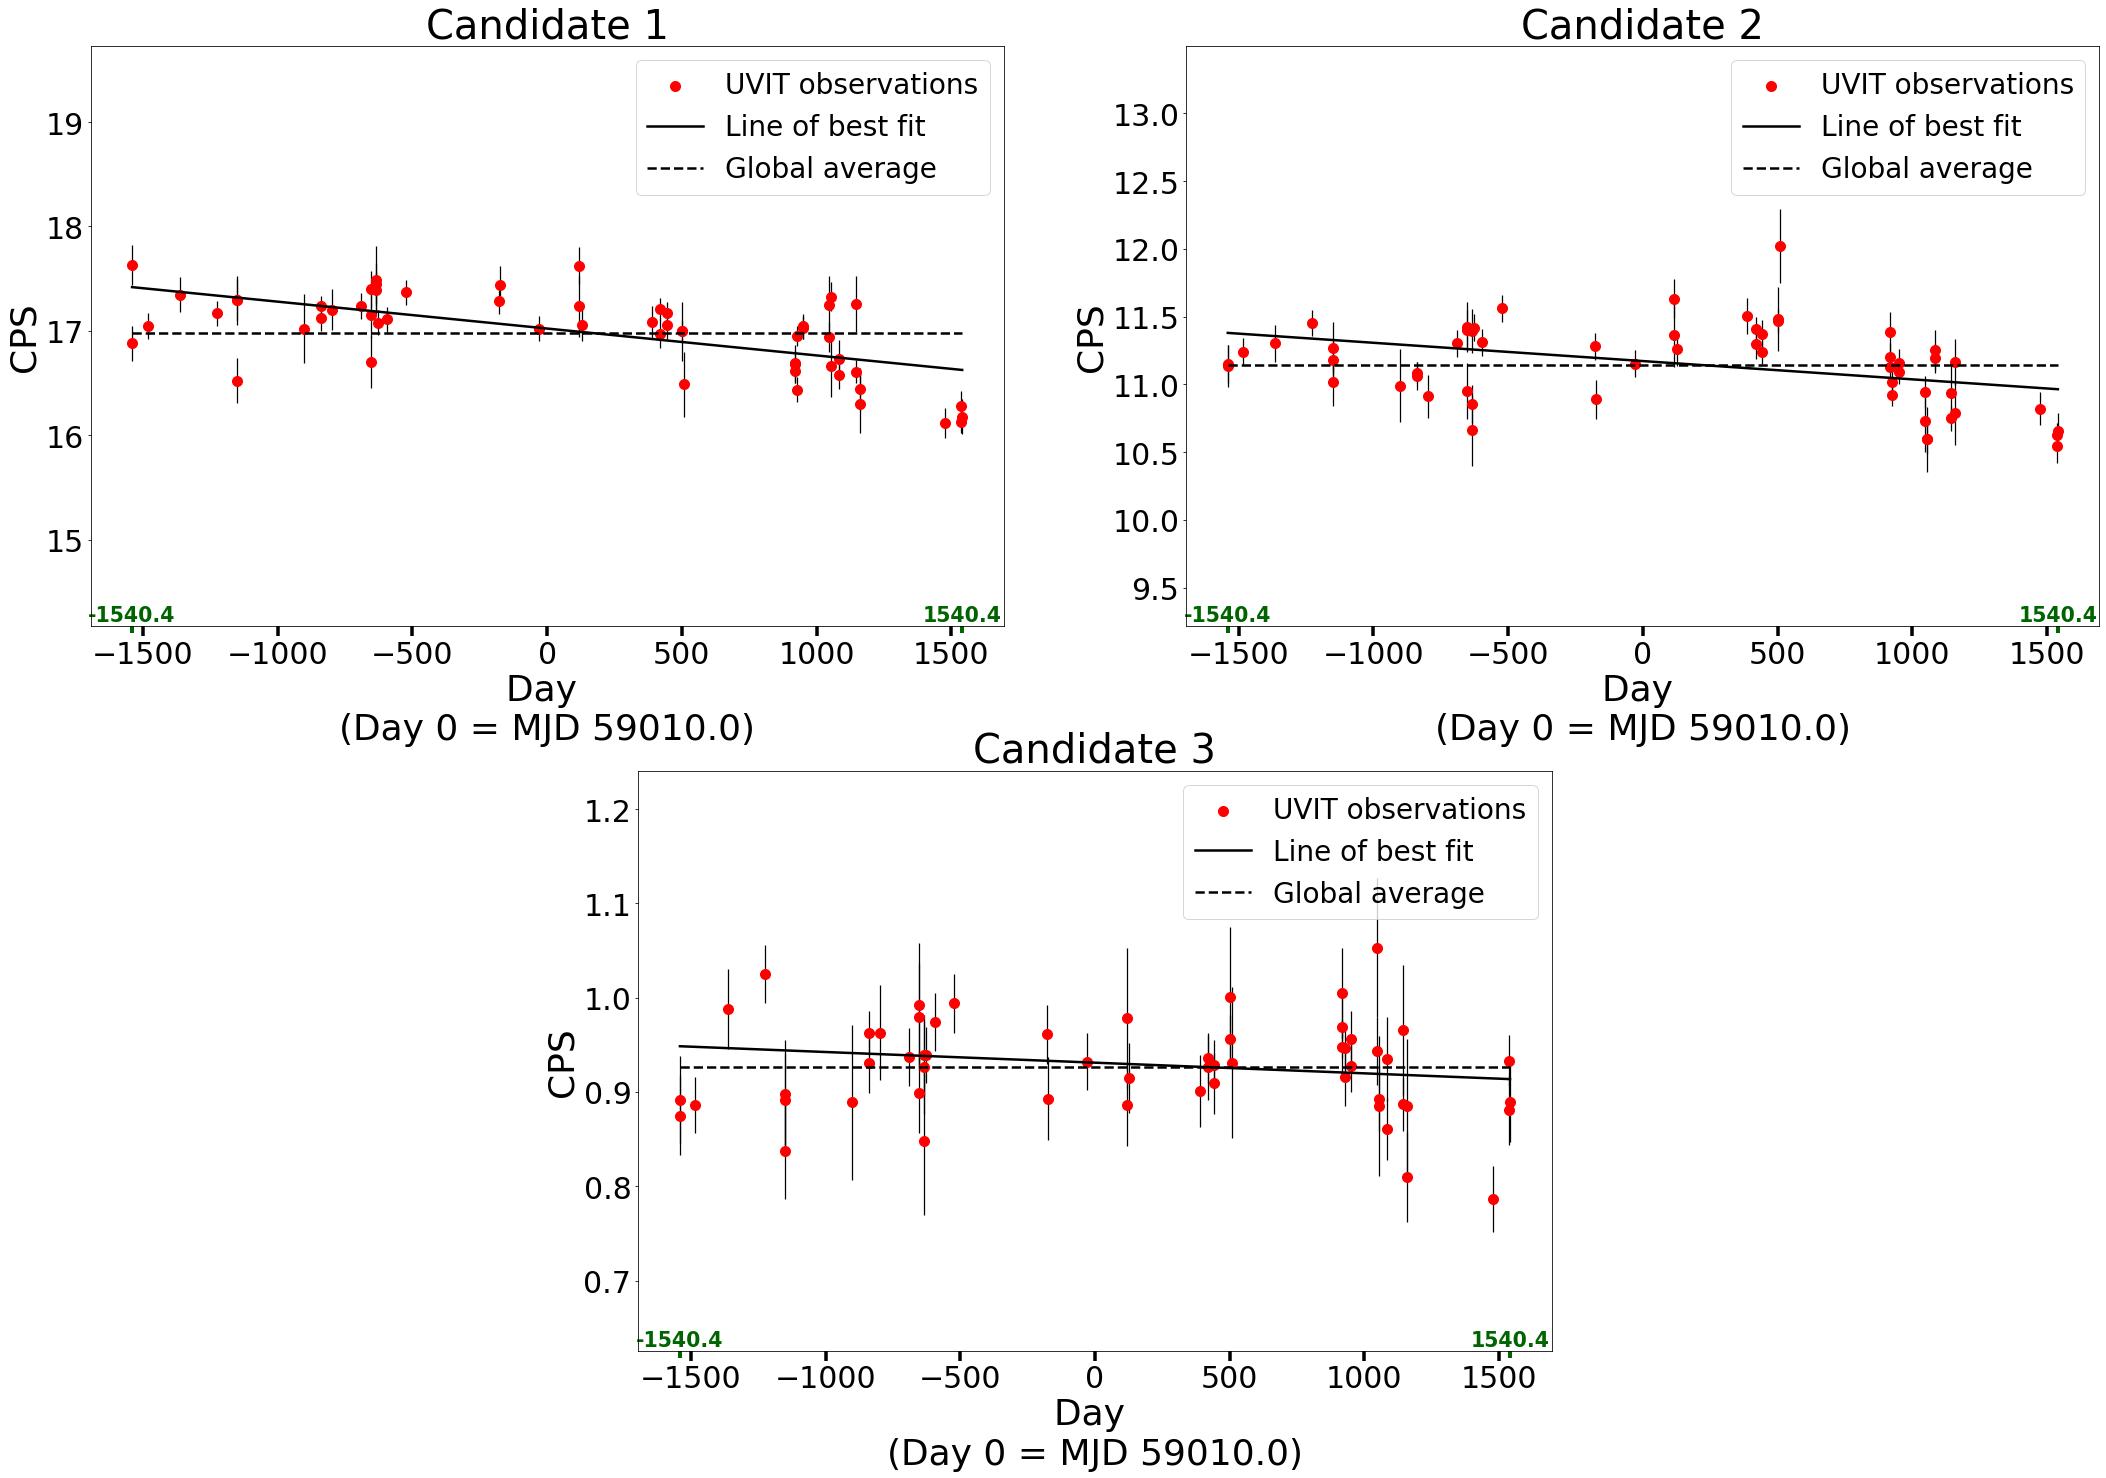

In [18]:

fig = plt.figure(figsize = (36,24))
gs = gridspec.GridSpec(2,4)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 1:3])
axs = [ax1, ax2, ax3]

scale = 0.1


for a, ax in enumerate(axs):
    
    candidate = eval("candidate_" + str(a+1))
    y_predicted = eval("y_predicted_" + str(a+1))
    
    
    x = candidate['MJD_Time'] - mjd_midpoint_ngc188_uvit[a]
    y = candidate['Final flat-field corrected CPS']
    yerr = candidate['Errors for the final flat-field corrected CPS']
    
    ax.scatter(x, y, label = 'UVIT observations', marker = 'o', color = 'red', s = 100, zorder = 2)
    ax.plot(x, y_predicted[0], label = 'Line of best fit', color = 'black', linewidth = 2.5, zorder = 3)
    ax.errorbar(x, y, yerr = yerr, linestyle = '', color = 'black', elinewidth = 1.25, zorder = 1)
    ax.hlines(y = globavg_ngc188_uvit_cps[a], xmin = x[0], xmax = x[len(candidate)-1], label = 'Global average', linestyle = 'dashed', 
              color = 'black', linewidth = 2.5, zorder = 4)
    
    first_tick = np.round(x[0], 1)
    last_tick = np.round(x[len(candidate)-1], 1)
    
    minor_ticks = [first_tick, last_tick]
    ax.set_xticks(minor_ticks, minor = True)
    ax.set_xticklabels(minor_ticks, minor = True, color = 'darkgreen', fontweight = 'bold')
    
    ax.tick_params(axis = 'x', which = 'major', direction = 'out', labelsize = 30, length = 10, width = 3.5)
    ax.tick_params(axis = 'x', which = 'minor', direction = 'out', color = 'darkgreen', labelsize = 20.5, length = 7, width = 4, pad = -28)
    ax.tick_params(axis = 'y', labelsize = 30)
    
    ax.set_xlabel('Day \n(Day 0 = MJD ' + str(np.round(mjd_midpoint_ngc188_uvit[a], 1)) + ')', fontsize = 36)
    ax.set_ylabel('CPS', fontsize = 36)

    
    scale_max = ((np.max(candidate['Final flat-field corrected CPS'])*scale) + np.max(candidate['Final flat-field corrected CPS']) + 
                 np.max(candidate['Errors for the final flat-field corrected CPS']))
    scale_min = (np.min(candidate['Final flat-field corrected CPS']) - (np.min(candidate['Final flat-field corrected CPS'])*scale) - 
                 np.max(candidate['Errors for the final flat-field corrected CPS']))
    
    ax.set_ylim([scale_min, scale_max])
    ax.set_title('Candidate ' + str(a+1), size = 40)
    ax.legend(fontsize = 28)
    
plt.subplots_adjust(hspace = 0.25, wspace = 0.5)
plt.savefig("plots/senstivity_variation_NGC188", facecolor = 'white', bbox_inches = 'tight')
plt.show()


# HZ4

#### Coordinates of the field center of the FITS image in instrument coordinates

In [19]:

field_center_coordinates_HZ4 = pd.read_csv("HZ4/Data_info/HZ4_field_center_coordinates.csv")
field_center_coordinates_HZ4 = field_center_coordinates_HZ4.reset_index(drop = True)

""" The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here. """

field_center_coordinates_HZ4


,Observation ID,x_c,y_c
0,AS1C02_002T01_9000000888_uvt_05,2318.1135,2449.3505
1,AS1C02_002T01_9000000888_uvt_10,2296.0104,2472.8350
2,AS1C02_002T01_9000000888_uvt_11,2326.4021,2497.7010
3,AS1C02_002T01_9000006092_uvt_07,2357.2543,2403.3024
4,AS1C02_002T01_9000006092_uvt_08,2417.1168,2401.0000
5,AS1C03_013T01_9000001586_uvt_20,2389.9485,2376.1340
6,AS1C03_013T01_9000001586_uvt_21,2407.9072,2419.4192
7,AS1C03_013T01_9000001586_uvt_22,2362.3016,2354.5620
8,AS1C03_013T01_9000001586_uvt_26,2429.3788,2413.8995
9,AS1C04_010T01_9000003158_uvt_05,2429.3788,2401.0000


#### Removing flat-fielding corrections

In [20]:

# Arrays for storing the data
# ---------------------------

X_FF_coord_HZ4 = []; Y_FF_coord_HZ4 = []
raw_cps_arr_HZ4 = []; raw_cps_err_arr_HZ4 = []; FF_arr_HZ4 = []
AVGFRMRT_HZ4 = []



HZ4_cps = pd.read_csv("HZ4/source_HZ4_cps.csv")

for i in range(0, len(field_center_coordinates_HZ4)):
    XC = field_center_coordinates_HZ4['x_c'][i] - 1  # X coordinate of the centre of the field
    YC = field_center_coordinates_HZ4['y_c'][i] - 1  # Y coordinate of the centre of the field
    
    """ The (XC, YC) coordinates were noted down after manually looking at each image in SAODS9. The coordinates follow +1 indexing here. 
        To bring it to zero indexing, we subtract -1 from the coordinates. """

    obs_ID = field_center_coordinates_HZ4['Observation ID'][i][:-7]
    obs_ID_orbit = field_center_coordinates_HZ4['Observation ID'][i][-6:]
    
    source_coord_I = HZ4_cps.loc[HZ4_cps['Observation ID'] == obs_ID + '_' + obs_ID_orbit]
    
    
    # Converting source coordinates in the image to FLAT array coordinates
    # --------------------------------------------------------------------
    
    x = source_coord_I['x_center_source'].item() # X coordinate of star in the image
    y = source_coord_I['y_center_source'].item() # Y coordinate of star in the image

    x_flat = 256 + ((x - XC)/8) # X Coordinate of star in Flat array (appiled conversion)
    y_flat = 256 + ((y - YC)/8) # Y Coordinate of star in Flat array (appiled conversion)
    
    X_FF_coord_HZ4.append(x_flat)
    Y_FF_coord_HZ4.append(y_flat)
    
    
    
    # Removing flatfielding corrections
    # ---------------------------------
    
    measured_cps = source_coord_I['source_cps'].item() # measured counts per second of the star
    measured_cps_err = source_coord_I['source_err_cps'].item()
    
    FF_val = avgFlat(x_flat, y_flat) # Average flat field value
    raw_cps_val = measured_cps/FF_val # CPS after removing the effect of flatfielding (Raw CPS)
    raw_cps_err_val = measured_cps_err/FF_val
      
    FF_arr_HZ4.append(FF_val)
    raw_cps_arr_HZ4.append(raw_cps_val)
    raw_cps_err_arr_HZ4.append(raw_cps_err_val)
    

    
    # Calculating AVGFRMT
    # -------------------

    I_img_file = glob("HZ4/Data_astrobrowse/" + obs_ID + "/" + obs_ID_orbit + "*FIIP*F1I_l2img.fits.gz")
    hdu = fits.open(I_img_file[0])
    INT_TIME = hdu[0].header['INT_TIME']
    avg_frmrt = 1/INT_TIME
    AVGFRMRT_HZ4.append(avg_frmrt)


#### Applying aperture and saturation corrections

In [21]:

CPS_sat_corr_HZ4 = [] ; CPS_err_sat_corr_HZ4 = []

for i in range(0, len(field_center_coordinates_HZ4)):
    
    obs = field_center_coordinates_HZ4['Observation ID'][i]
    framecount_per_sec = AVGFRMRT_HZ4[i]
    CPS = np.array(raw_cps_arr_HZ4[i])
    CPS_err = np.array(raw_cps_err_arr_HZ4[i])
    FF = np.array(FF_arr_HZ4[i])
    
    CPF = CPS / framecount_per_sec
    CPF_err = CPS_err / framecount_per_sec
    
    CPS_sat_corr_val, CPS_err_sat_corr_val = apply_all_correction(CPS, CPS_err, radius, framecount_per_sec)
    
    CPS_sat_corr_HZ4.append(CPS_sat_corr_val)
    CPS_err_sat_corr_HZ4.append(CPS_err_sat_corr_val)


#### Reintroducing flat-field corrections

In [22]:

FF_corr_CPS_HZ4 = np.multiply(CPS_sat_corr_HZ4, FF_arr_HZ4)
FF_corr_err_CPS_HZ4 = np.multiply(CPS_err_sat_corr_HZ4, FF_arr_HZ4)


### Creating the master sheet

In [23]:

# Observation IDs in the field_center_coordinates dataframe

obs_HZ4 = field_center_coordinates_HZ4['Observation ID']



#---------------------------------------------------------------------------#



# Data Columns

x_coord_I_HZ4 = [] ; y_coord_I_HZ4 = []
coordinates_I_HZ4 = [] ; coordinates_FF_HZ4 = []

source_aperture_CPS_HZ4 = [] ; err_source_aperture_CPS_HZ4 = []
HZ4 = pd.DataFrame()

date_HZ4 = []; exposure_time_HZ4 = []; mjd_time_HZ4 = []; UTC_HZ4 = []; median_background_HZ4 = []



#---------------------------------------------------------------------------#



# Background of the image

bkg_img_file_HZ4 = "HZ4/source_detection/source_bkg_HZ4.txt"
data_txt_HZ4 = np.genfromtxt(bkg_img_file_HZ4, delimiter = ',', dtype = None, encoding = None)
data_HZ4 = np.array([row.split() for row in data_txt_HZ4]).T

observation_id_HZ4 = data_HZ4[0]
med_bkg_HZ4 = data_HZ4[3]
median_bkg_HZ4 = pd.DataFrame(zip(observation_id_HZ4, med_bkg_HZ4), columns = ['Observation ID', 'Median_background'])



#---------------------------------------------------------------------------#



for i in range(0, len(field_center_coordinates_HZ4)):
    
    obs_id = field_center_coordinates_HZ4['Observation ID'][i][:-7]
    orbit = field_center_coordinates_HZ4['Observation ID'][i][-6:]
    
    ce_file_path = "HZ4/Data_astrobrowse/" + obs_id + "/" + orbit + "_" + obs_id + "uvtFIIPC44F1_l2ce.fits.gz"
    I_img_file = "HZ4/Data_astrobrowse/" + obs_id + "/" + orbit + "_" + obs_id + "uvtFIIPC44F1I_l2img.fits.gz"
    
    
    
    # UTC
    # ---
    
    hdu_list = fits.open(ce_file_path)
    event_data = Table(hdu_list[1].data)
    met = np.median(np.unique(event_data['MJD_L2']))     # mission ellapsed time in seconds
    mjd = met_to_mjd(met)
    mjd_time_HZ4.append(mjd)
    t = Time(mjd, format = 'mjd')
    t_utc = t.utc.datetime
    UTC_HZ4.append(t_utc)
    
    
    
    # Date of observation
    # -------------------
    
    date_val = t_utc.strftime("%d/%m/%Y")
    date_HZ4.append(date_val)
    
    
    
    # Exposure time
    # -------------
    
    hdu = fits.open(I_img_file)
    exp_time_val = hdu[0].header['EXP_TIME']
    exposure_time_HZ4.append(exp_time_val)
    
    
    
    # Median background
    # -----------------
    
    matched_obs_id_HZ4 = median_bkg_HZ4.loc[median_bkg_HZ4['Observation ID'] == obs_id + "_" + orbit]
    median_bkg_val = matched_obs_id_HZ4['Median_background'].tolist()
    median_background_HZ4.append(median_bkg_val)
    
    
    
    # Reading csv file for HZ 4
    # -------------------------
    
    source_coord_I = HZ4_cps.loc[HZ4_cps['Observation ID'] == obs_id + '_' + orbit]
    
    # Source coordinate information in instrumentation coordinates (I)
    x_coord_I = source_coord_I['x_center_source'].item()
    y_coord_I = source_coord_I['y_center_source'].item()
    coordinates_I_HZ4.append([x_coord_I, y_coord_I])
                                 
    # Background subtracted aperture CPS
    measured_cps = source_coord_I['source_cps'].item()     # measured counts per second of the source
    measured_err_cps = source_coord_I['source_err_cps'].item()
    source_aperture_CPS_HZ4.append(measured_cps)
    err_source_aperture_CPS_HZ4.append(measured_err_cps)
    
    
    
# Source coordinates in FF
for xff, yff, in zip(X_FF_coord_HZ4, Y_FF_coord_HZ4):
    coordinates_FF_HZ4.append([xff, yff])


median_background_round_HZ4 = []
for i in median_background_HZ4:
    temp = '{:.3e}'.format(float(i[0]))
    median_background_round_HZ4.append(temp)


In [24]:

coordinates_I_HZ4_round = []; coordinates_FF_HZ4_round = []


for i,j in zip(coordinates_I_HZ4, coordinates_FF_HZ4):
    
    temp_i = [round(num,1) for num in i]
    coordinates_I_HZ4_round.append(temp_i)
    
    temp_ff = [round(num,1) for num in j]
    coordinates_FF_HZ4_round.append(temp_ff)


HZ4 = pd.DataFrame(zip(obs_HZ4, date_HZ4, exposure_time_HZ4, mjd_time_HZ4, coordinates_I_HZ4_round, median_background_round_HZ4, 
                       source_aperture_CPS_HZ4, err_source_aperture_CPS_HZ4, coordinates_FF_HZ4_round, FF_arr_HZ4, raw_cps_arr_HZ4, 
                       CPS_sat_corr_HZ4, FF_corr_CPS_HZ4, FF_corr_err_CPS_HZ4), 
                   columns = ['Observation', 'Date of observation', 'Exposure time', 'MJD_Time', 'Source coordinates (I)', 'Median background',
                              'Bkg-subtracted aperture CPS', 'Errors for the bkg-subtracted CPS', 'Flat-field coordinates', 
                              'Flat-field Correction', 'Non-flat fielded CPS (without FF)', 'Aperture and Saturation corrected CPS', 
                              'Final CPS (with FF, aper, sat corrections)', 'Errors for the final CPS (with FF, aper, sat corrections)'])

HZ4 = HZ4.sort_values(by = 'MJD_Time', ascending = True).reset_index(drop = True)
HZ4 = HZ4.round({'Exposure time':3, 'Bkg-subtracted aperture CPS':3, 'Errors for the bkg-subtracted CPS':3, 'Flat-field Correction':3, 
                 'Non-flat fielded CPS (without FF)':3, 'Aperture and Saturation corrected CPS':3, 'Final CPS (with FF, aper, sat corrections)':3, 
                 'Errors for the final CPS (with FF, aper, sat corrections)':3})

# # conditionally delete rows where Exposure time < 130 seconds
# HZ4 = HZ4.drop(HZ4[HZ4['Exposure time'] < 130].index).reset_index(drop = True)

HZ4 = HZ4.reset_index(drop = True)
HZ4.to_csv("master_sheets/HZ4.csv", index = False)

HZ4

,Observation,Date of observation,Exposure time,MJD_Time,Source coordinates (I),Median background,Bkg-subtracted aperture CPS,Errors for the bkg-subtracted CPS,Flat-field coordinates,Flat-field Correction,Non-flat fielded CPS (without FF),Aperture and Saturation corrected CPS,"Final CPS (with FF, aper, sat corrections)","Errors for the final CPS (with FF, aper, sat corrections)"
0,AS1C02_002T01_9000000888_uvt_11,16/12/2016,374.802,57738.419638,"[2421.7, 2130.5]",6.228e-05,19.614,0.229,"[268.0, 210.2]",1.002,19.573,23.386,23.434,0.259
1,AS1C02_002T01_9000000888_uvt_10,16/12/2016,374.918,57738.424038,"[2422.2, 2131.2]",6.329e-05,19.882,0.230,"[271.9, 213.4]",1.001,19.865,23.756,23.777,0.260
2,AS1C02_002T01_9000000888_uvt_05,16/12/2016,374.924,57738.428432,"[2420.9, 2130.7]",6.459e-05,20.306,0.233,"[269.0, 216.3]",0.998,20.342,24.362,24.319,0.263
3,AS1C03_013T01_9000001586_uvt_22,06/10/2017,335.540,58032.170751,"[2391.9, 2051.8]",5.968e-05,19.750,0.243,"[259.8, 218.3]",1.000,19.747,23.606,23.610,0.274
4,AS1C03_013T01_9000001586_uvt_21,06/10/2017,374.241,58032.238622,"[2454.3, 2151.6]",6.201e-05,19.901,0.231,"[261.9, 222.6]",0.997,19.959,23.876,23.807,0.261
5,AS1C03_013T01_9000001586_uvt_26,06/10/2017,260.612,58032.242386,"[2453.8, 2151.8]",6.215e-05,19.921,0.276,"[259.2, 223.4]",0.998,19.958,23.875,23.830,0.313
6,AS1C03_013T01_9000001586_uvt_20,06/10/2017,244.792,58032.305527,"[2436.0, 2056.7]",6.187e-05,19.629,0.283,"[261.9, 216.2]",1.000,19.622,23.448,23.457,0.320
7,AS1C04_010T01_9000003158_uvt_05,12/09/2019,357.914,58738.384319,"[2437.8, 2068.9]",6.114e-05,19.983,0.236,"[257.2, 214.6]",1.002,19.944,23.856,23.903,0.267
8,AS1C04_010T01_9000003158_uvt_16,12/09/2019,357.884,58738.388746,"[2437.8, 2070.4]",6.382e-05,19.266,0.232,"[252.3, 212.9]",1.003,19.201,22.915,22.993,0.262
9,AS1C04_010T01_9000003158_uvt_17,12/09/2019,270.786,58738.392595,"[2439.3, 2072.3]",6.607e-05,19.722,0.270,"[249.9, 209.9]",1.004,19.649,23.482,23.570,0.305


#### Plotting the light curve

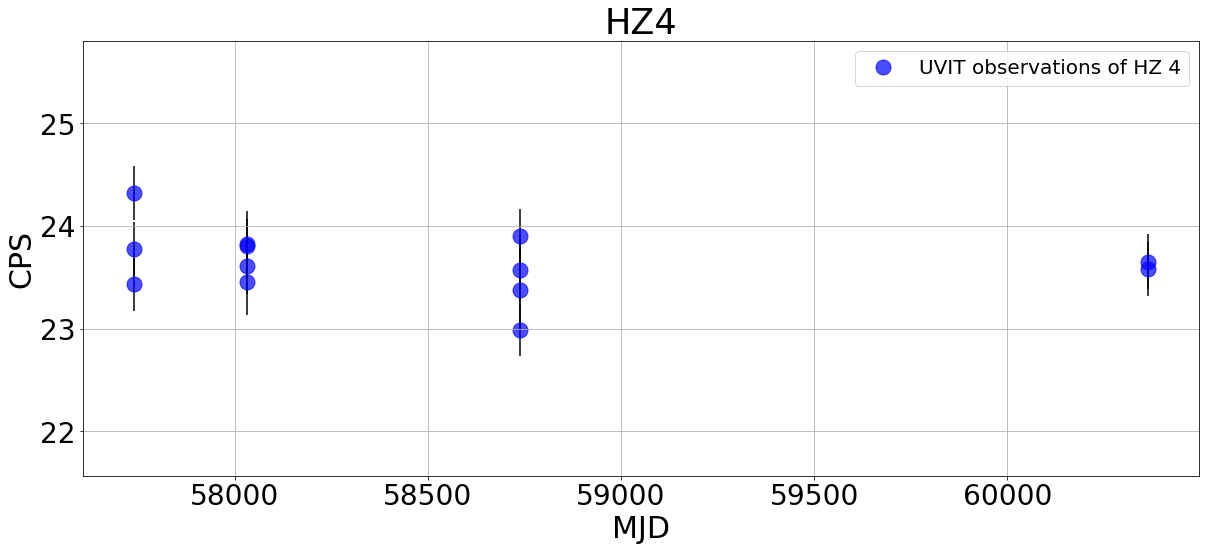

In [25]:

plt.figure(figsize = (20,8))
plt.title('HZ4', fontsize = 35)

cps_column_name = 'Final CPS (with FF, aper, sat corrections)'

max_flux = np.max([np.max(HZ4[cps_column_name]), np.max(HZ4[cps_column_name])])
min_flux = np.min([np.min(HZ4[cps_column_name]), np.min(HZ4[cps_column_name])])

y_error_image = HZ4['Errors for the final CPS (with FF, aper, sat corrections)']
max_err = np.max(y_error_image)
min_err = np.min(y_error_image)

scale = 0.045

scale_max = (np.max(max_flux)*scale) + np.max(max_flux) + np.max(max_err)
scale_min = np.min(min_flux) - (np.min(min_flux)*scale) - np.max(max_err)

plt.plot(HZ4['MJD_Time'], HZ4[cps_column_name], 'o', label = 'UVIT observations of HZ 4', markersize = 15, color = 'blue', alpha = 0.7, zorder = 1)
plt.errorbar(HZ4['MJD_Time'], HZ4[cps_column_name], yerr = y_error_image, color = 'black', elinewidth = 1.5, linestyle = '', zorder = 0)
plt.xlabel('MJD', fontsize = 30)
plt.ylabel('CPS', fontsize = 30)
plt.tick_params(axis = 'x', labelsize = 28)
plt.tick_params(axis = 'y', labelsize = 28)
plt.ylim(scale_min, scale_max)
plt.legend(fontsize = 20)
plt.grid()
plt.show()
    

#### Combining the data points for each observation ID by taking the average of the episode CPS

In [26]:

x_HZ4 = HZ4['MJD_Time']
y_HZ4 = HZ4['Final CPS (with FF, aper, sat corrections)']
y_errors_HZ4 = HZ4['Errors for the final CPS (with FF, aper, sat corrections)']


data_point_1 = range(0,3)
data_point_2 = range(3,7)
data_point_3 = range(7,11)
data_point_4 = range(11,13)
data_range = [data_point_1, data_point_2, data_point_3, data_point_4]


x_HZ4_mean = [] ; y_HZ4_mean = [] ; y_errors_HZ4_mean = [] ; obs_ID_HZ4 = []


for r in data_range:
    
    unique_id = HZ4['Observation'][r].iloc[0][:-7]
    
    x = np.mean(x_HZ4[r])
    y = np.mean(y_HZ4[r])
    
    # Adding errors in quadrature
    error_points = y_errors_HZ4[r]
    num_err = len(error_points)
    sum_of_squares = sum(error ** 2 for error in error_points)
    y_err = math.sqrt(sum_of_squares)/num_err
    
    x_HZ4_mean.append(x)
    y_HZ4_mean.append(y)
    y_errors_HZ4_mean.append(y_err)
    obs_ID_HZ4.append(unique_id)

x_HZ4_mean = np.array(x_HZ4_mean) ; y_HZ4_mean = np.array(y_HZ4_mean) ; y_errors_HZ4_mean = np.array(y_errors_HZ4_mean)
obs_ID_HZ4 = np.array(obs_ID_HZ4)


In [27]:

HZ4_mean = pd.DataFrame(zip(obs_ID_HZ4, x_HZ4_mean, y_HZ4_mean, y_errors_HZ4_mean), columns = ['Observation ID', 'Date of observation (MJD)', 
                                                                                               'Final CPS (with FF, aper, sat corrections)', 
                                                                                               'Errors for the final CPS (with FF, aper, sat corrections)'])
HZ4_mean


,Observation ID,Date of observation (MJD),"Final CPS (with FF, aper, sat corrections)","Errors for the final CPS (with FF, aper, sat corrections)"
0,AS1C02_002T01_9000000888,57738.424036,23.843333,0.150499
1,AS1C03_013T01_9000001586,58032.239322,23.676000,0.146536
2,AS1C04_010T01_9000003158,58738.404111,23.460000,0.155133
3,AS1C02_002T01_9000006092,60364.551465,23.619500,0.187383


### Long-term sensitivity variation

MJD midpoint: 59051.5
Global average CPS: 23.639 0.08

Slope: -7.759065569863641e-05  Error: 9.323621782524814e-05
Intercept at 59051.5 MJD : 23.617  Error: 0.098
Chi-square value: 2.379

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.257
Model:                            WLS   Adj. R-squared:                 -0.114
Method:                 Least Squares   F-statistic:                    0.6925
Date:                Mon, 14 Jul 2025   Prob (F-statistic):              0.493
Time:                        17:41:54   Log-Likelihood:                 2.7162
No. Observations:                   4   AIC:                            -1.432
Df Residuals:                       2   BIC:                            -2.660
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

/home/akanksha/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


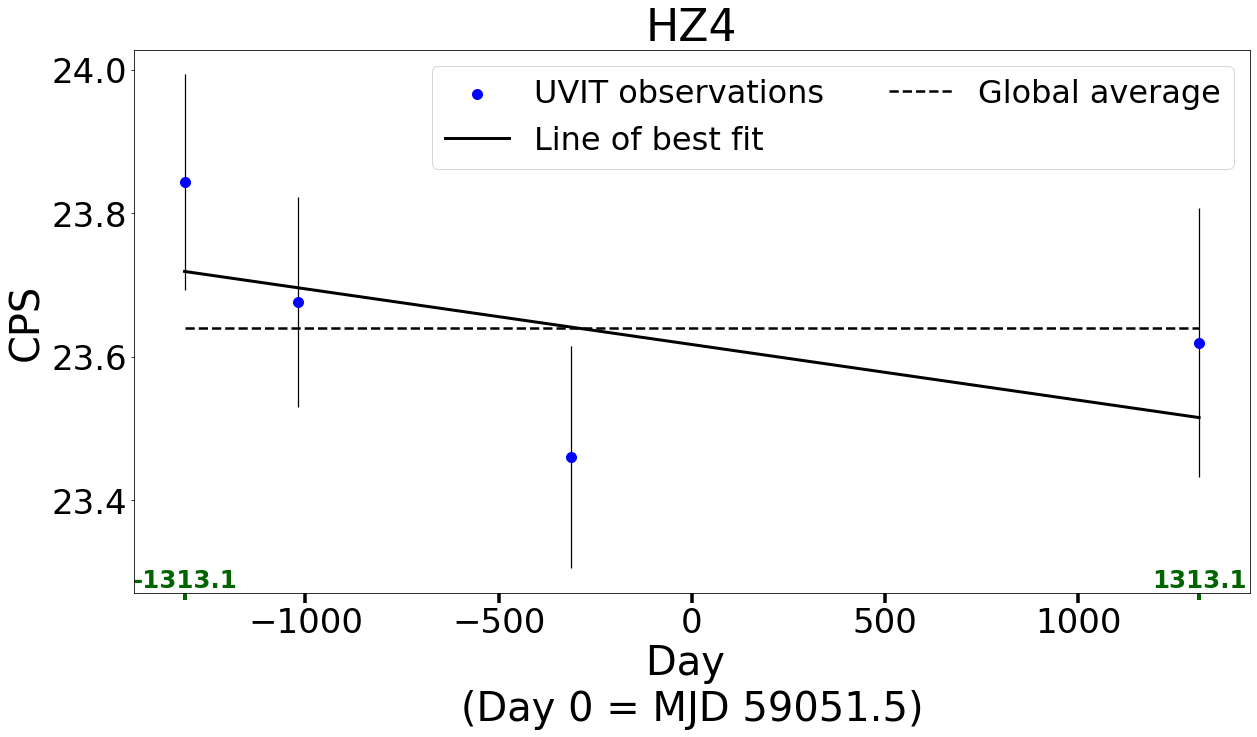

In [28]:

# MJD midpoint
# ------------

mjd_midpoint_hz4_uvit = ( HZ4['MJD_Time'].iloc[-1] + HZ4['MJD_Time'].iloc[0] ) / 2
print('MJD midpoint:', np.round(mjd_midpoint_hz4_uvit, 1))



# Global average
# --------------

globavg_hz4_uvit_cps = np.mean(HZ4['Final CPS (with FF, aper, sat corrections)'])
error_points = y_errors_HZ4_mean
num_err = len(error_points)
sum_of_squares = sum(error ** 2 for error in error_points)
y_err = math.sqrt(sum_of_squares)/num_err

print('Global average CPS:', np.round(globavg_hz4_uvit_cps, 3), np.round(y_err, 3))



# Performing least squares
# ------------------------

x_HZ4_new = x_HZ4_mean - mjd_midpoint_hz4_uvit
alpha_HZ4_mean, cov_HZ4_mean = optimize.curve_fit(func_best_fit, xdata = x_HZ4_new, ydata = y_HZ4_mean, sigma = y_errors_HZ4_mean)

m_fit_HZ4_mean = alpha_HZ4_mean[0]
c_fit_HZ4_mean = alpha_HZ4_mean[1]
d_m_HZ4_mean = np.sqrt(cov_HZ4_mean[0][0])
d_c_HZ4_mean = np.sqrt(cov_HZ4_mean[1][1])

y_predicted_HZ4_mean = m_fit_HZ4_mean*(x_HZ4_new) + c_fit_HZ4_mean

residuals_HZ4_mean = y_HZ4_mean - y_predicted_HZ4_mean
chi_squared_fit_HZ4_mean = np.sum((residuals_HZ4_mean ** 2) / y_errors_HZ4_mean**2)

print("")

print('Slope:', m_fit_HZ4_mean, ' Error:', d_m_HZ4_mean)
print('Intercept at ' + str(np.round(mjd_midpoint_hz4_uvit, 1)) + ' MJD :', np.round(c_fit_HZ4_mean, 3), ' Error:', np.round(d_c_HZ4_mean, 3))    
print('Chi-square value:', np.round(chi_squared_fit_HZ4_mean, 3))
print("")



#---------------------------------------------------------------------------#

# STATSMODELS

X_HZ4 = np.column_stack([np.ones_like(y_HZ4_mean), x_HZ4_new])
model_HZ4 = sm.WLS(y_HZ4_mean, X_HZ4, weights = 1/y_errors_HZ4_mean**2)
fit_HZ4 = model_HZ4.fit()

# Get prediction results
pred_HZ4 = fit_HZ4.get_prediction(X_HZ4)
pred_summary_HZ4 = pred_HZ4.summary_frame(alpha = 0.05)  # 95% confidence intervals

# Extract confidence intervals
ci_lower_HZ4 = pred_summary_HZ4['mean_ci_lower']
ci_upper_HZ4 = pred_summary_HZ4['mean_ci_upper']

print(fit_HZ4.summary())

#---------------------------------------------------------------------------#

print("-------------------------------------------------------------")
print("Rounded off values")
print("")
print('Slope:', format_value_and_error(m_fit_HZ4_mean, d_m_HZ4_mean))
print('Intercept at ' + str(np.round(mjd_midpoint_hz4_uvit, 1)) + ' MJD :', format_value_and_error(c_fit_HZ4_mean, d_c_HZ4_mean))
print('Global average CPS:', format_value_and_error(globavg_hz4_uvit_cps, y_err))
print("")

#---------------------------------------------------------------------------#



# Plotting
# --------

scale = 0.015

fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.set_title('HZ4', fontsize = 44)
ax.scatter(x_HZ4_new, y_HZ4_mean, label = 'UVIT observations', marker = 'o', color = 'blue', s = 100, zorder = 2)
ax.plot(x_HZ4_new, y_predicted_HZ4_mean, label = 'Line of best fit', color = 'black', linewidth = 3, zorder = 3)
ax.errorbar(x_HZ4_new, y_HZ4_mean, yerr = y_errors_HZ4_mean, linestyle = '', color = 'black', elinewidth = 1.25, zorder = 1)
ax.hlines(y = globavg_hz4_uvit_cps, xmin = (x_HZ4_new)[0], xmax = (x_HZ4_new)[len(x_HZ4_mean)-1], label = 'Global average', linestyle = 'dashed', 
          color = 'black', linewidth = 2.5, zorder = 4)

first_tick = np.round(x_HZ4_new[0], 1)
last_tick = np.round(x_HZ4_new[len(x_HZ4_mean)-1], 1)
minor_ticks = [first_tick, last_tick]
ax.set_xticks(minor_ticks, minor = True)
ax.set_xticklabels(minor_ticks, minor = True, color = 'darkgreen', fontweight = 'bold')

ax.tick_params(axis = 'x', which = 'major', direction = 'out', labelsize = 34, length = 10, width = 3.5)
ax.tick_params(axis = 'x', which = 'minor', direction = 'out', color = 'darkgreen', labelsize = 24.5, length = 7, width = 4, pad = -32)
ax.tick_params(axis = 'y', labelsize = 34)

ax.set_xlabel('Day \n(Day 0 = MJD ' + str(np.round(mjd_midpoint_hz4_uvit, 1)) + ')', fontsize = 40)
ax.set_ylabel('CPS', fontsize = 40)

scale_max = (np.max(y_HZ4_mean)*scale) + np.max(y_HZ4_mean) + np.max(y_errors_HZ4_mean)
scale_min = np.min(y_HZ4_mean) - (np.min(y_HZ4_mean)*scale) - np.max(y_errors_HZ4_mean)

ax.legend(fontsize = 32, ncols = 2)
plt.savefig("plots/senstivity_variation_HZ4", facecolor = 'white', bbox_inches = 'tight')
plt.show()


# Median background levels enclosed in a 12 sub-pixel aperture radius

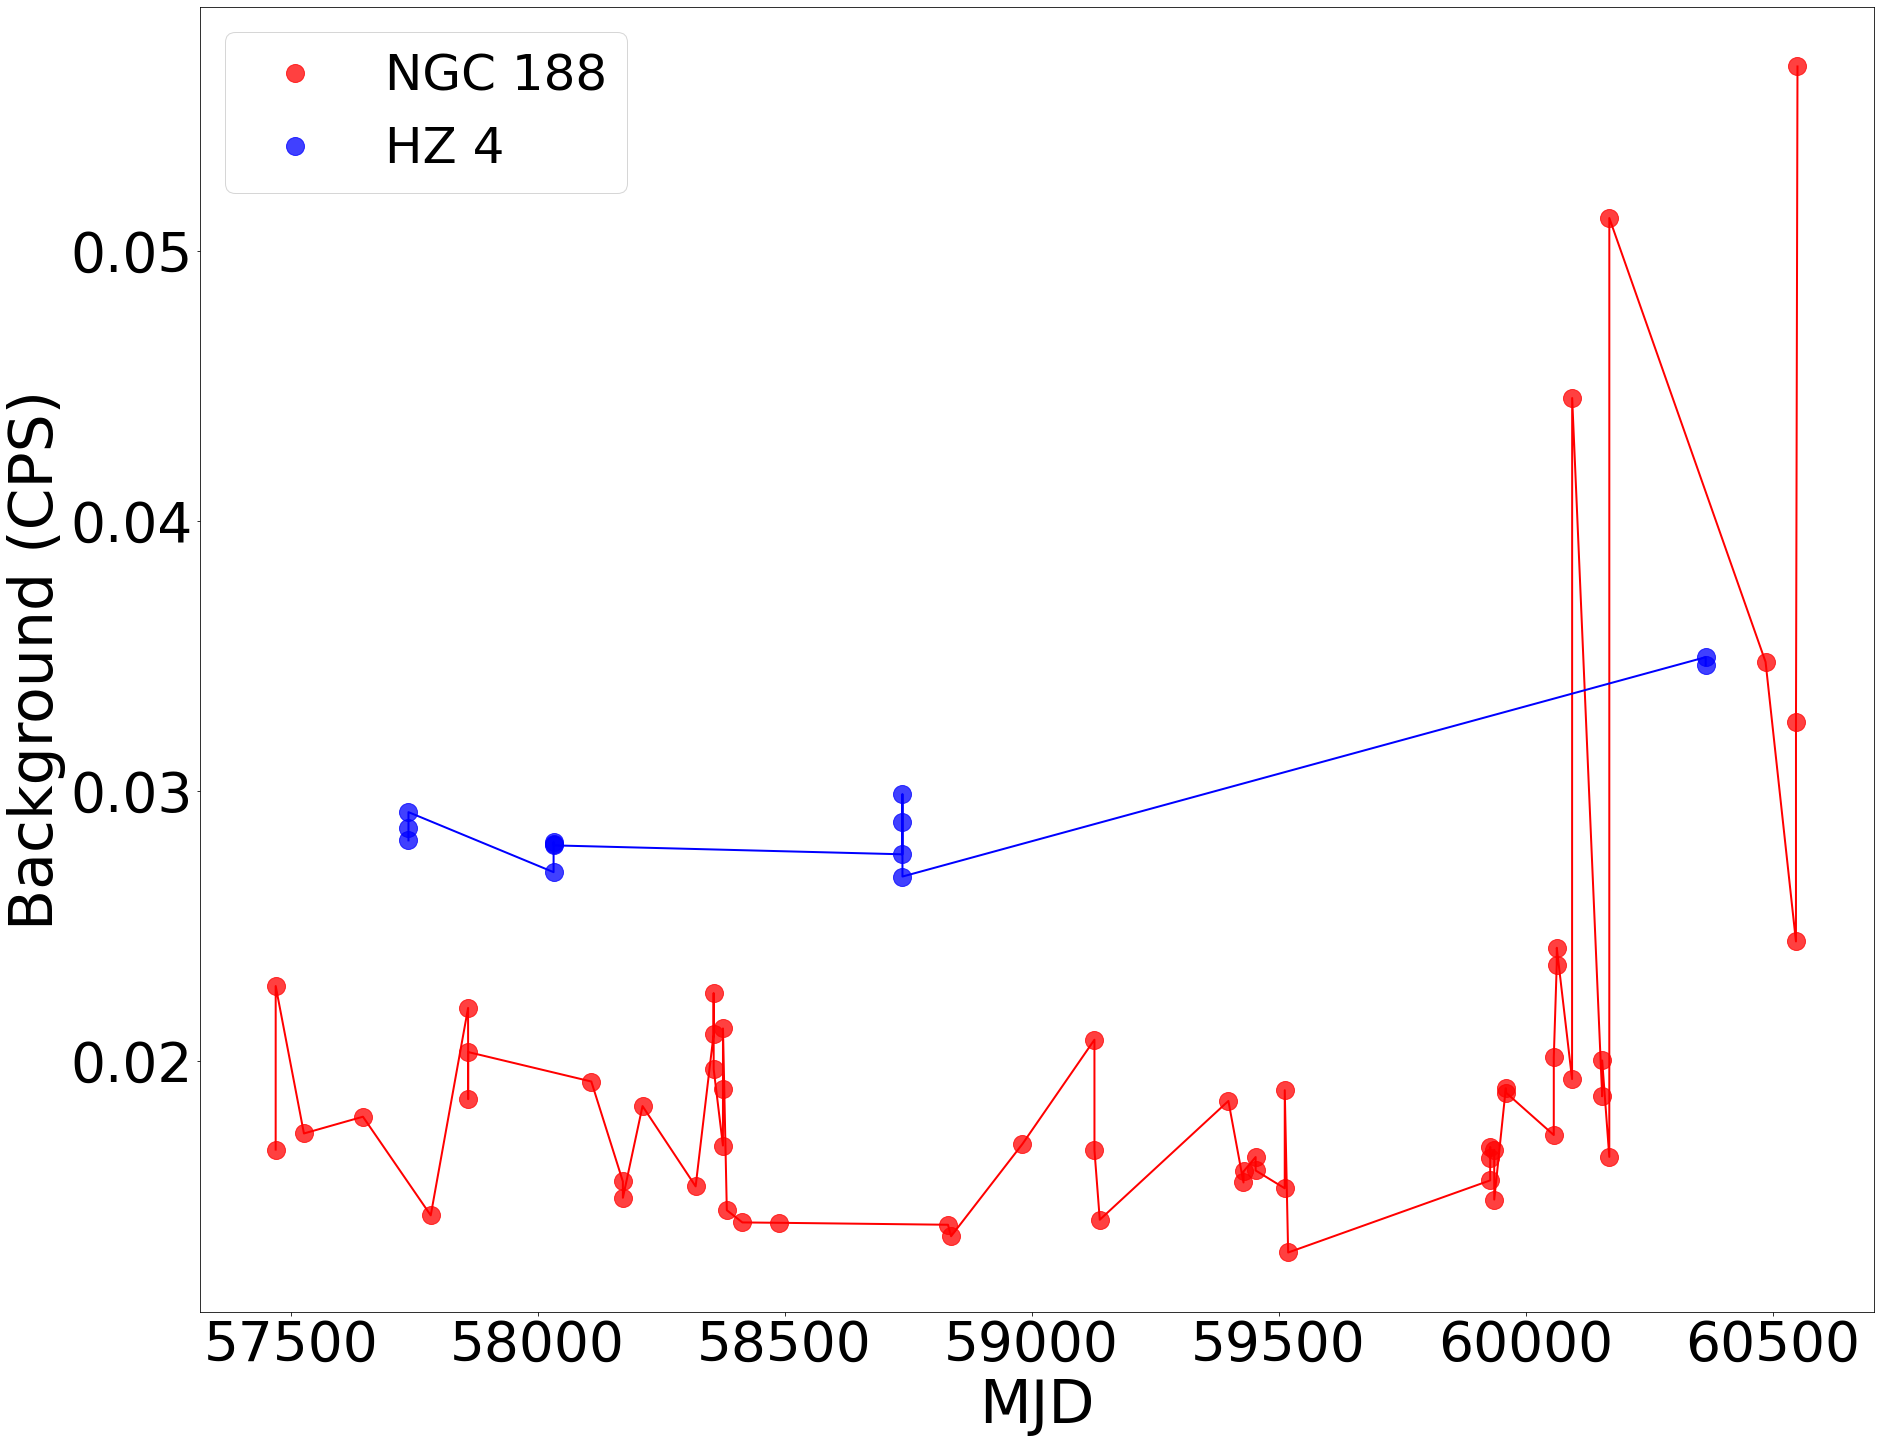

In [29]:

median_bkg_img_HZ4 = pd.to_numeric(HZ4['Median background'])
median_bkg_img = pd.to_numeric(candidate_1['Median background'])



# Scaling the bkg
# ---------------

# HZ4
median_bkg_img_HZ4 = np.array(median_bkg_img_HZ4)
median_bkg_img_HZ4 = median_bkg_img_HZ4 * ( (np.pi)*((12)**2) )

# NGC 188
median_bkg_img = np.array(median_bkg_img)
median_bkg_img = median_bkg_img * ( (np.pi)*((12)**2) )



# Plotting
# --------

fig, (ax) = plt.subplots(figsize = (30,24))
ax.plot(candidate_1['MJD_Time'], median_bkg_img, 'o', label = 'NGC 188', markersize = 18, color = 'r', alpha = 0.75)
ax.plot(candidate_1['MJD_Time'], median_bkg_img, linewidth = 2, color = 'r')
ax.plot(HZ4['MJD_Time'], median_bkg_img_HZ4, 'o', label = 'HZ 4', markersize = 18, color = 'b', alpha = 0.75)
ax.plot(HZ4['MJD_Time'], median_bkg_img_HZ4, linewidth = 2, color = 'b')
ax.set_xlabel('MJD', fontsize = 60)
ax.set_ylabel('Background (CPS)', fontsize = 60)
ax.tick_params(axis = 'x', labelsize = 55)
ax.tick_params(axis = 'y', labelsize = 55)
ax.legend(fontsize = 50)
plt.savefig("plots/median_bkg_NGC188_HZ4.png", facecolor = 'white', bbox_inches = 'tight')
plt.show()
